In [34]:
import sys
sys.path.append("../") # adding the path to read the utils file
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from shap import plots, Explanation, DeepExplainer
from sklearn.preprocessing import StandardScaler
import time
import shap
from tqdm import tqdm
import pickle
from sklearn.cluster import KMeans
from utils import *
from mlp import MLP
import torch
from yellowbrick.model_selection import LearningCurve
from sklearn.preprocessing import LabelEncoder
import glob

pd.set_option('display.max_columns', None)


In [35]:
# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Here I force the model to run on cpu since it's a small one is goes faster on a cpu then a gpu
device = 'cpu'

In [36]:
ds = pd.concat([pd.read_csv(csv_file, engine='pyarrow', index_col='id') for csv_file in glob.glob('../datasets/NFS-2023-TE/*.csv')], ignore_index=True)
ds.head()

expiration_id         src_ip            src_mac   src_oui  src_port  \
0              1  192.168.10.50  00:19:b9:0a:69:f1  00:19:b9     33898   
1              1  192.168.10.50  00:19:b9:0a:69:f1  00:19:b9     33904   
2              0  192.168.10.14  b8:ac:6f:36:07:ee  b8:ac:6f     59555   
3              0  192.168.10.14  b8:ac:6f:36:07:ee  b8:ac:6f     59135   
4              0  192.168.10.50  00:19:b9:0a:69:f1  00:19:b9       123   

         dst_ip            dst_mac   dst_oui  dst_port  protocol  ip_version  \
0  192.168.10.3  18:66:da:9b:e3:7d  18:66:da       389         6           4   
1  192.168.10.3  18:66:da:9b:e3:7d  18:66:da       389         6           4   
2  192.168.10.3  18:66:da:9b:e3:7d  18:66:da        53        17           4   
3  65.55.44.109  00:c1:b1:14:eb:31  00:c1:b1       443         6           4   
4   129.6.15.29  00:c1:b1:14:eb:31  00:c1:b1       123        17           4   

   vlan_id  bidirectional_first_seen_ms  bidirectional_last_seen_ms  \
0        0                1499342340490               1499342453585   
1        0                1499342340491               1499342453964   
2        0                1499342357298               1499342357299   
3        0                1499342357299               1499342417611   
4        0                1499342395411               1499342395442   

   bidirectional_duration_ms  bidirectional_packets  bidirectional_bytes  \
0                     113095                     36                12216   
1                     113473                     54                15605   
2                          1                      2                  296   
3                      60312                     18                 7559   
4                         31                      2                  180   

   src2dst_first_seen_ms  src2dst_last_seen_ms  src2dst_duration_ms  \
0          1499342340490         1499342453585               113095   
1          1499342340491         1499342453964               113473   
2          1499342357298         1499342357298                    0   
3          1499342357299         1499342417611                60312   
4          1499342395411         1499342395411                    0   

   src2dst_packets  src2dst_bytes  dst2src_first_seen_ms  \
0               24           6418          1499342340490   
1               34           7926          1499342340491   
2                1             93          1499342357299   
3               10           2888          1499342357349   
4                1             90          1499342395442   

   dst2src_last_seen_ms  dst2src_duration_ms  dst2src_packets  dst2src_bytes  \
0         1499342453585               113095               12           5798   
1         1499342453918               113427               20           7679   
2         1499342357299                    0                1            203   
3         1499342417610                60261                8           4671   
4         1499342395442                    0                1             90   

   bidirectional_min_ps  bidirectional_mean_ps  bidirectional_stddev_ps  \
0                    66             339.333333               236.650194   
1                    66             288.981481               200.112750   
2                    93             148.000000                77.781746   
3                    60             419.944444               522.680700   
4                    90              90.000000                 0.000000   

   bidirectional_max_ps  src2dst_min_ps  src2dst_mean_ps  src2dst_stddev_ps  \
0                   989              66       267.416667         205.748880   
1                  1205              66       233.117647         173.216936   
2                   203              93        93.000000           0.000000   
3                  1514              60       288.800000         393.690177   
4                    90              90        90.000000           0.000000   

In [37]:
compute_ratio(ds,'label')

                            Ratio
label                            
BENIGN                      76.37
PortScan                    10.61
DoS Hulk                     7.49
DDoS                         4.41
DoS GoldenEye                0.37
DoS slowloris                0.25
FTP-Patator                  0.19
SSH-Patator                  0.14
DoS Slowhttptest             0.13
Bot                          0.03
Web Attack - Brute Force     0.01
Web Attack - XSS             0.00
Infiltration                 0.00
Web Attack - Sql Injection   0.00
Heartbleed                   0.00


In [38]:
ds = ds.drop(columns=feature_to_remove_NFS)

ricordarsi di fare fit una volta sola per tutti i dati e poi usare transform dove serve

In [39]:
scaler = StandardScaler()
scaler.fit(ds.drop(columns=['label']))

StandardScaler()

In [40]:
sample_weights = ds.label.value_counts().to_dict()

In [41]:
sample_weights['BENIGN'] = 738
sample_weights['PortScan'] = 738
sample_weights['DoS Hulk'] = 738
sample_weights['DDoS'] = 738
sample_weights['FTP-Patator'] = 738
sample_weights['DoS GoldenEye'] = 738
sample_weights['DoS slowloris'] = 738
sample_weights['SSH-Patator'] = 738
sample_weights['DoS Slowhttptest'] = 738

In [42]:
model = MLP(epoch=31, verbose=False, out_neurons=15, n_features=58, patience=31, first_layer=64, second_layer=32)
# since the minority classes are so small I will let the model to see the intier dataset before stopping

le = LabelEncoder()
le.fit(ds['label'])

rus = RandomUnderSampler(random_state=42, sampling_strategy=sample_weights)
X_res, y_res = rus.fit_resample(ds.drop(columns=['label']), ds['label'])
y_res = le.transform(y_res)

scaled_X_res = scaler.transform(X_res)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X_res, y_res, test_size = 0.2, random_state=12,  stratify=y_res)

In [44]:
if False:
    cv = 10
    visualizer = LearningCurve(estimator=model, cv=cv, scoring='f1_weighted', n_jobs=1, random_state=123)
    visualizer.fit(X_train, y_train)
    visualizer.show(outpath="mlp_data/learning_curve.png")


In [45]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(scaled_X_res, y_res)

5

In [46]:
avg_train_f1 = []
avg_test_f1 = []

for i, (train_index, test_index) in enumerate(skf.split(scaled_X_res, y_res)):
    print(f"Fold {i}:")
    model.fit(scaled_X_res[train_index], y_res[train_index])
    y_predicted_train = model.predict(scaled_X_res[train_index])
    y_predicted_test = model.predict(scaled_X_res[test_index])
    train_f1 = metrics.f1_score(y_res[train_index], y_predicted_train, average='weighted')
    test_f1 = metrics.f1_score(y_res[test_index], y_predicted_test, average='weighted')
    print(f"Train F1: {train_f1:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    avg_train_f1.append(train_f1)
    avg_test_f1.append(test_f1)

print(f"Average Train F1: {np.mean(avg_train_f1):.4f}")
print(f"Average Test F1: {np.mean(avg_test_f1):.4f}")

Fold 0:


Execution time:  2.7197482585906982
Train F1: 0.8653
Test F1: 0.8498
Fold 1:
Execution time:  2.4233202934265137
Train F1: 0.8567
Test F1: 0.8636
Fold 2:
Execution time:  2.3787269592285156
Train F1: 0.8919
Test F1: 0.8868
Fold 3:
Execution time:  2.5397751331329346
Train F1: 0.8831
Test F1: 0.8718
Fold 4:
Execution time:  2.4120216369628906
Train F1: 0.8762
Test F1: 0.8883
Average Train F1: 0.8746
Average Test F1: 0.8721


In [ ]:
model.fit(X_train, y_train)

Execution time:  2.908081293106079


In [ ]:
y_predicted_test = model.predict(X_test)
y_predicted_train = model.predict(X_train)

In [ ]:
# Function to create dataframe with metrics
def performanceMetricsDF(
    metricsObj, yTrain, yPredTrain, yTest, yPredTest, average="binary"
):
    measures_list = ["ACCURACY", "PRECISION", "RECALL", "F1 SCORE"]
    train_results = [
        metricsObj.accuracy_score(yTrain, yPredTrain),
        metricsObj.precision_score(yTrain, yPredTrain, average=average),
        metricsObj.recall_score(yTrain, yPredTrain, average=average),
        metricsObj.f1_score(yTrain, yPredTrain, average=average),
    ]
    test_results = [
        metricsObj.accuracy_score(yTest, yPredTest),
        metricsObj.precision_score(yTest, yPredTest, average=average),
        metricsObj.recall_score(yTest, yPredTest, average=average),
        metricsObj.f1_score(yTest, yPredTest, average=average),

    ]
    resultsDF = pd.DataFrame(
        {"Measure": measures_list, "Train": train_results, "Test": test_results}
    )
    return resultsDF

In [ ]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test, 'weighted')

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Measure     Train      Test
0   ACCURACY  0.884179  0.875821
1  PRECISION  0.865240  0.859968
2     RECALL  0.884179  0.875821
3   F1 SCORE  0.867869  0.859637

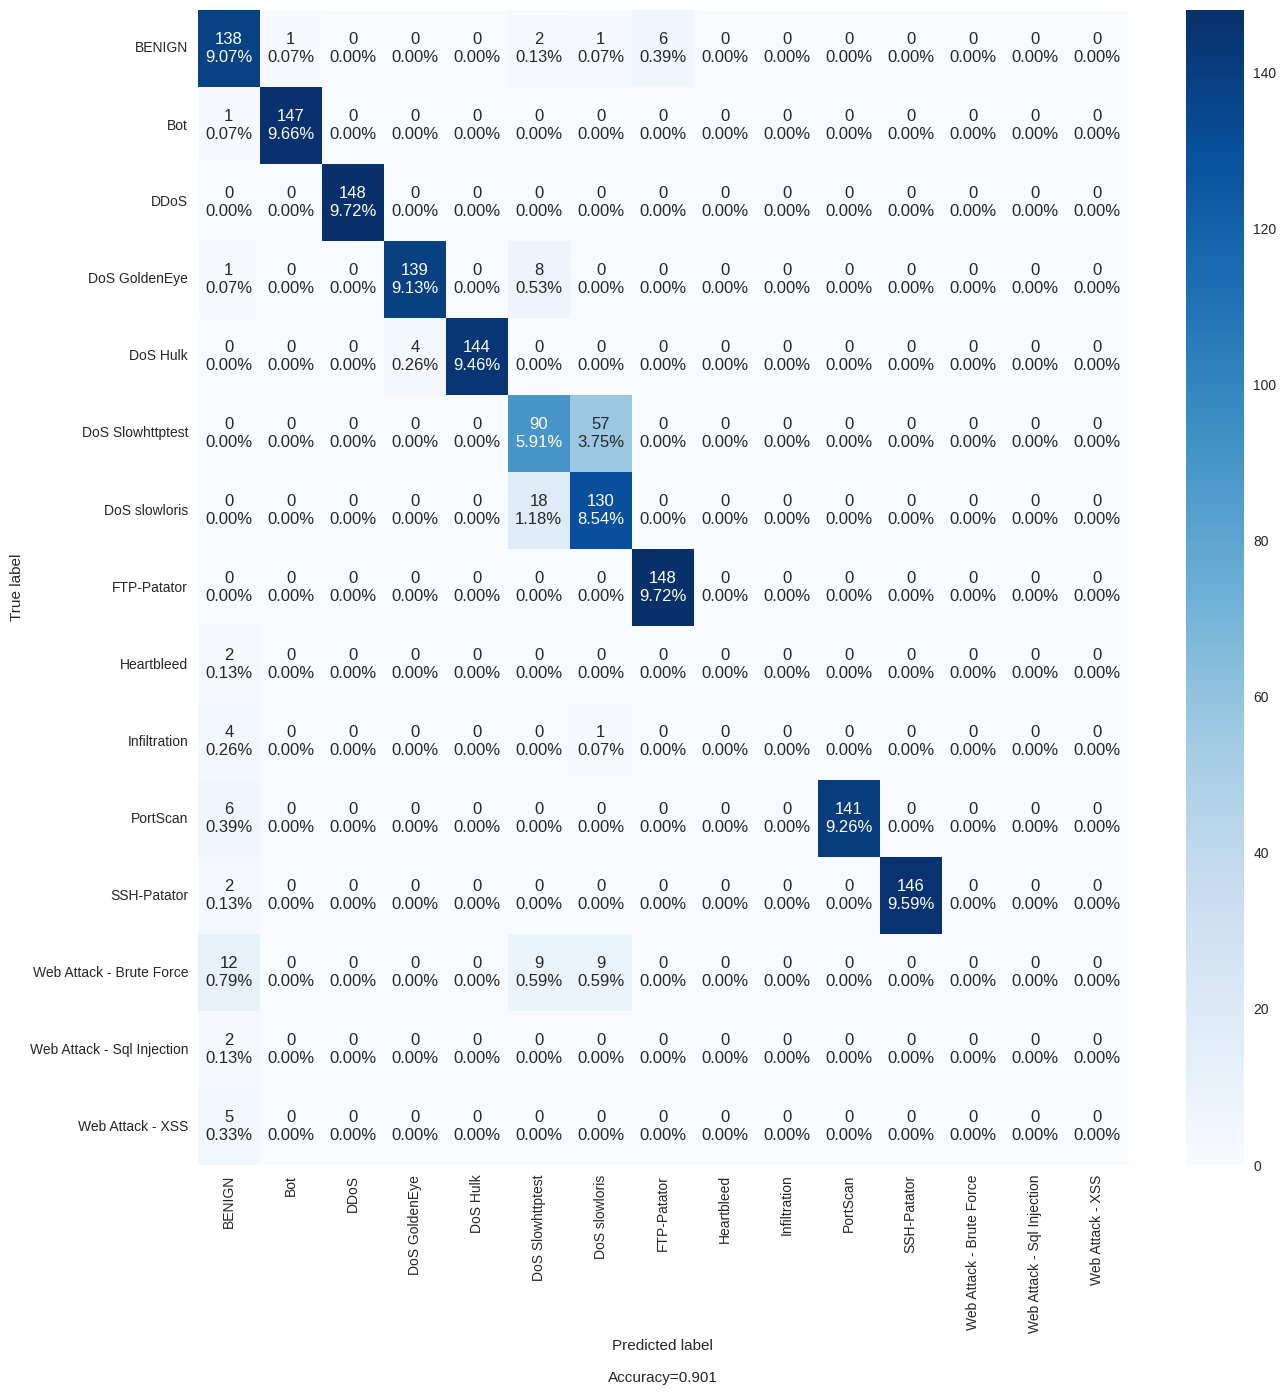

In [ ]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(le.classes_)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [ ]:
scaled_X_train = scaler.transform(X_train)

X does not have valid feature names, but StandardScaler was fitted with feature names


In [ ]:
cluster_centers = KMeans(n_clusters=1000, random_state=0).fit(scaled_X_train).cluster_centers_
cluster_centers = torch.from_numpy(cluster_centers.astype(np.float32)).to(device)

foreground = shap.sample(X_train, 1000)
foreground_tensor = torch.from_numpy(foreground.astype(np.float32)).to(device)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
Number of distinct clusters (972) found smaller than n_clusters (1000). Possibly due to duplicate points in X.


In [ ]:
%%time

explainer = DeepExplainer(model, cluster_centers)
sv = explainer.shap_values(foreground_tensor)

CPU times: user 1h 20min 22s, sys: 7.08 s, total: 1h 20min 29s
Wall time: 10min 31s


# Benign shap

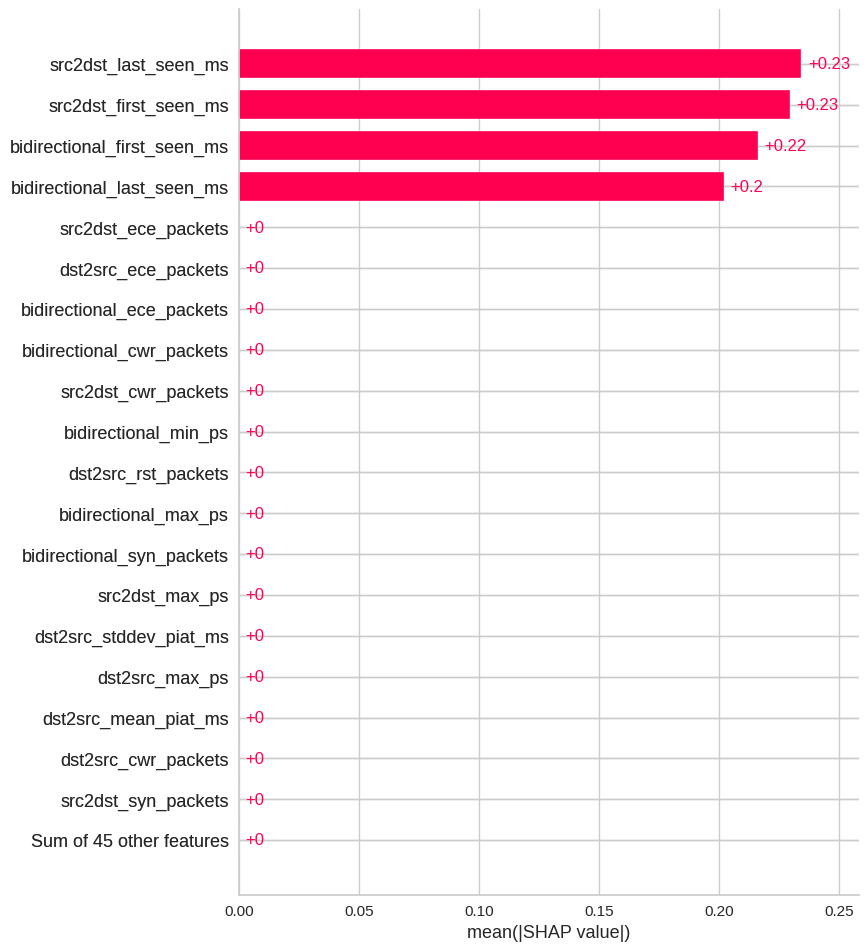

In [ ]:
exp = Explanation(sv[0],
              explainer.expected_value[0],
              data=foreground, 
              feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
plt.show()

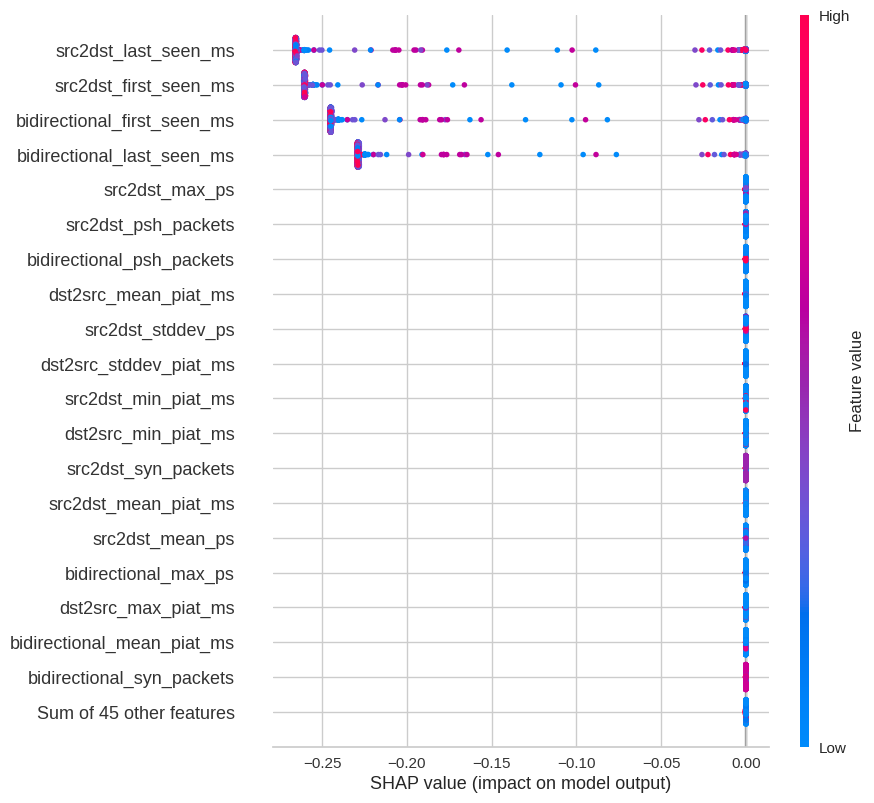

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

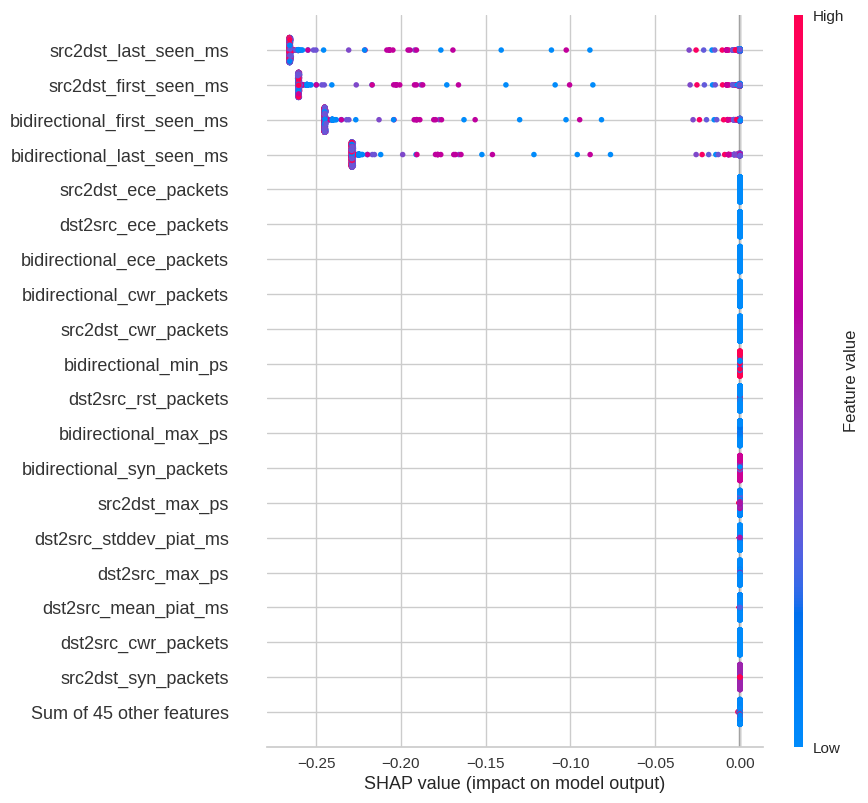

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

# Bot shap

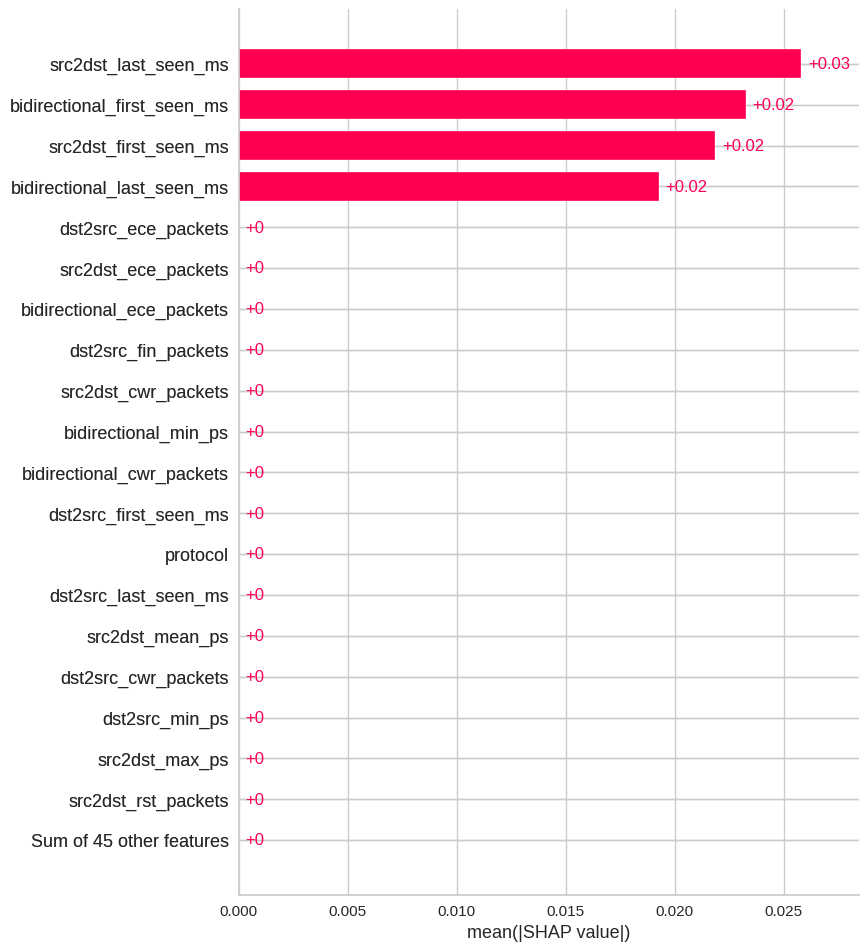

In [ ]:
exp = Explanation(sv[1],
              explainer.expected_value[1],
              data=foreground, 
              feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
plt.show()

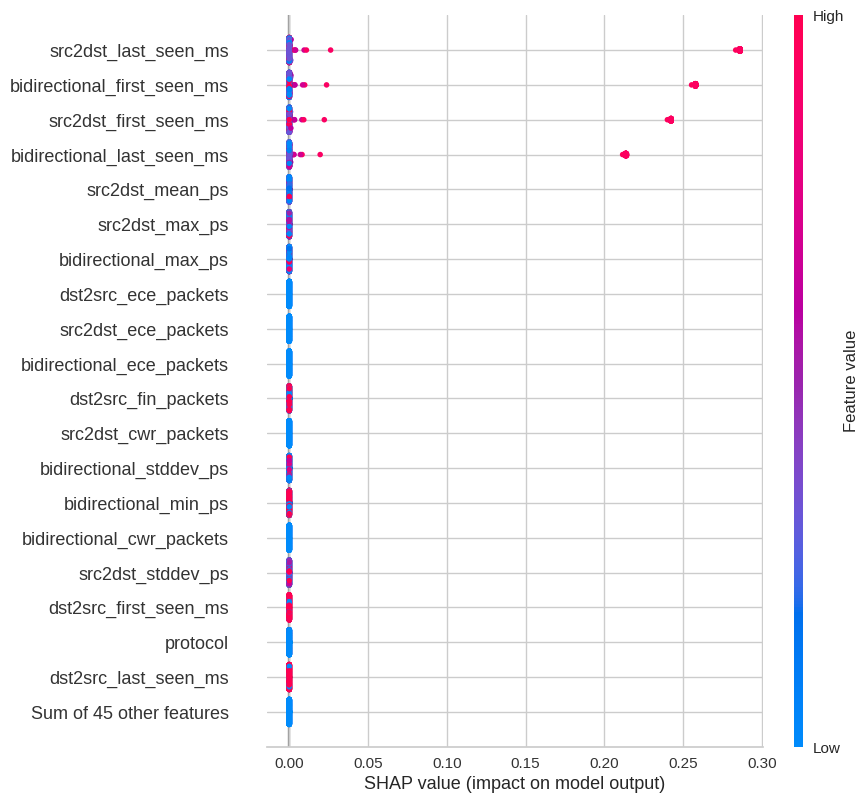

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

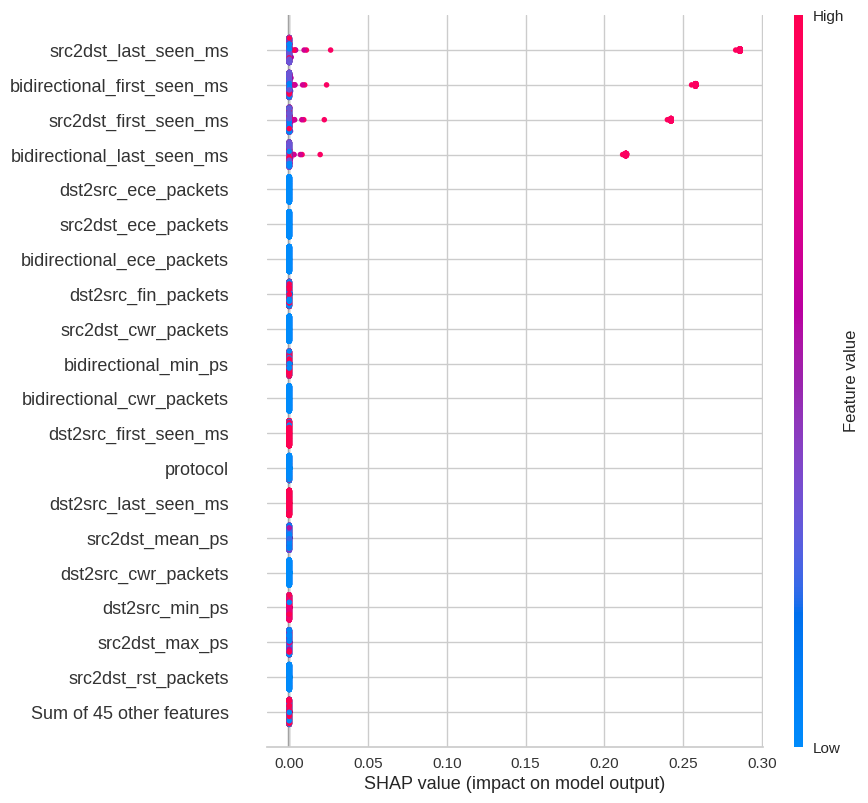

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

# DDoS shap

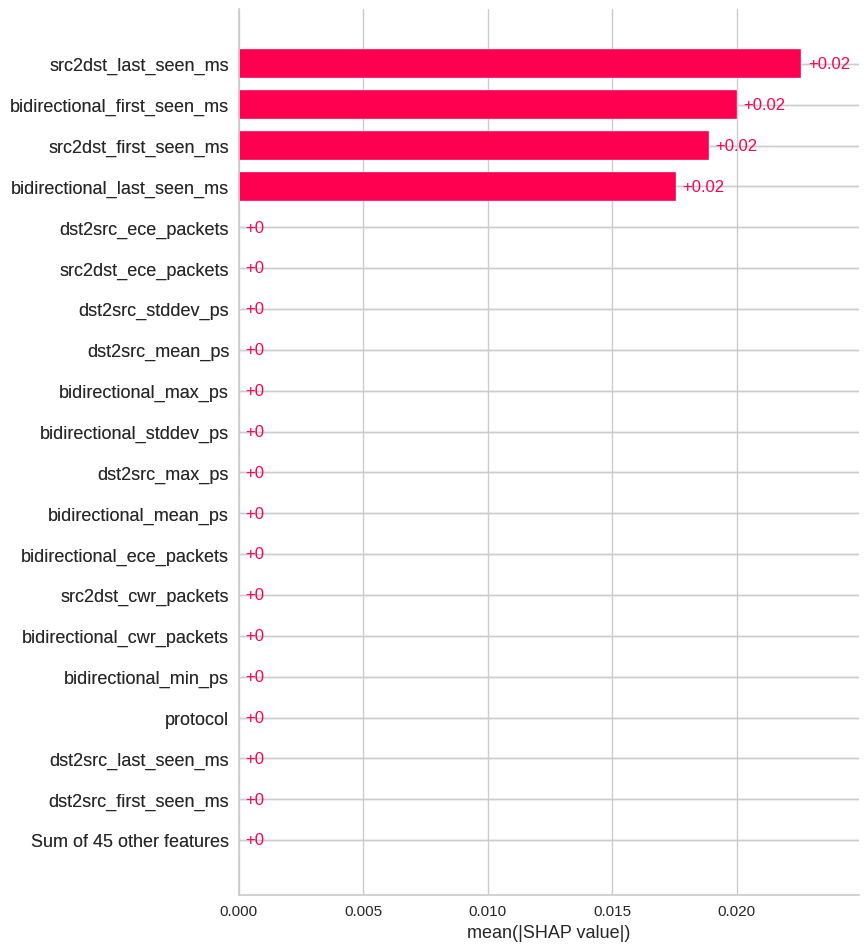

In [ ]:
exp = Explanation(sv[2],
              explainer.expected_value[2],
              data=foreground, 
              feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
plt.show()

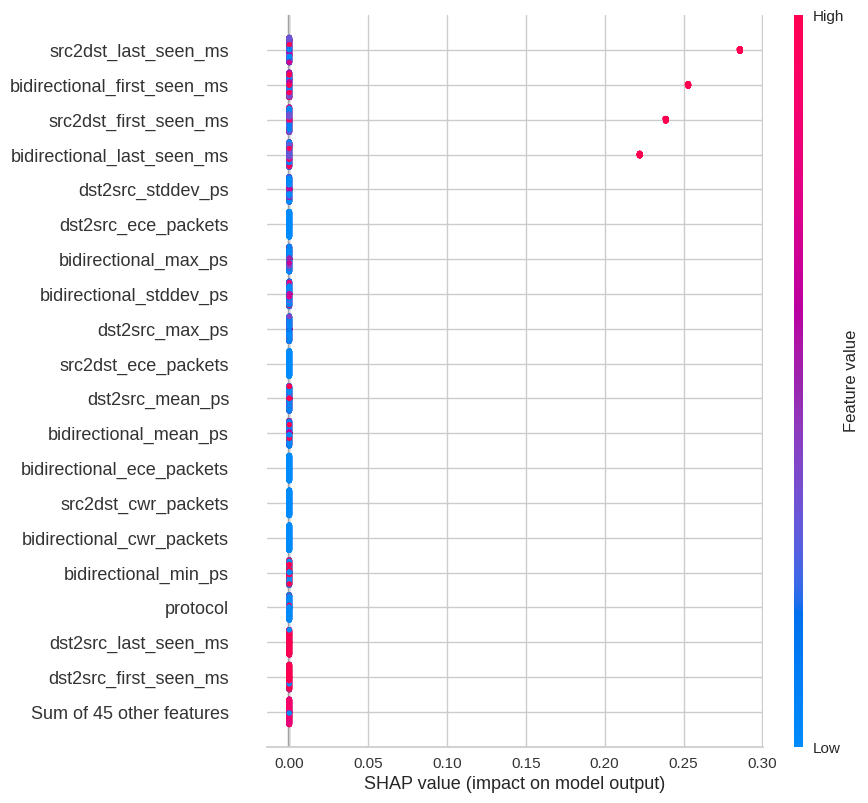

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

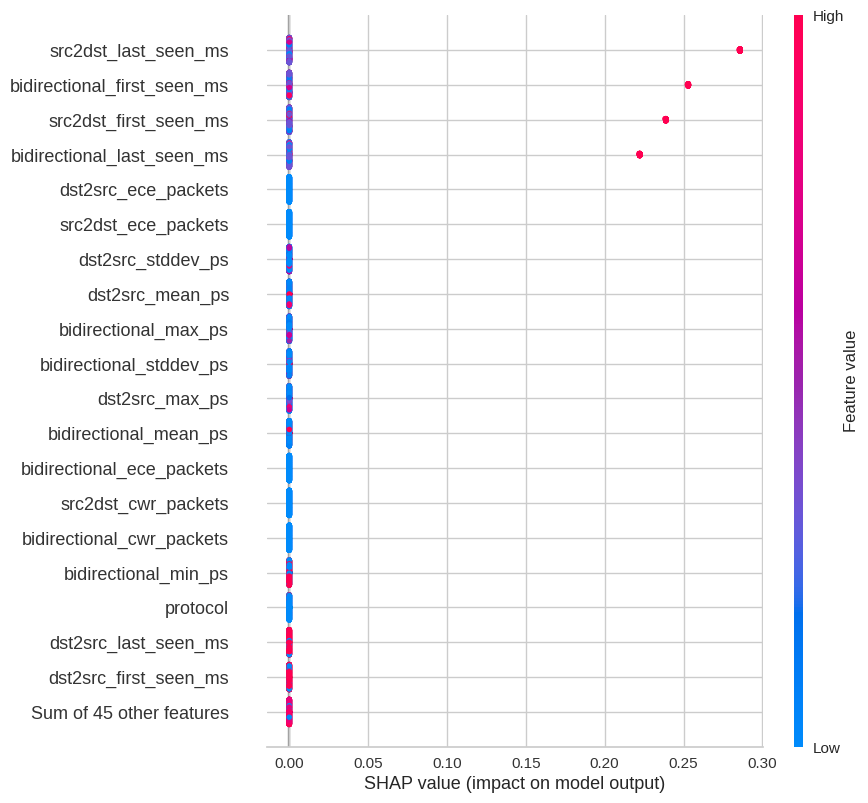

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## DoS GoldenEye shap

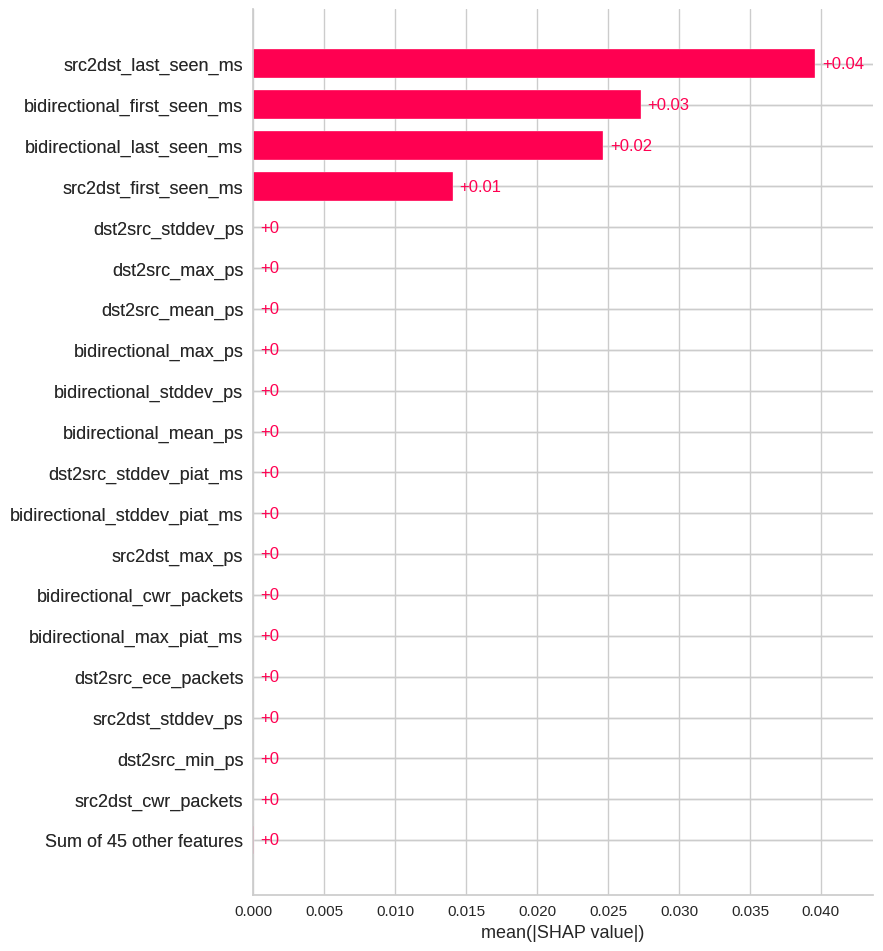

In [ ]:
exp = Explanation(sv[3],
              explainer.expected_value[3],
              data=foreground, 
              feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
plt.show()

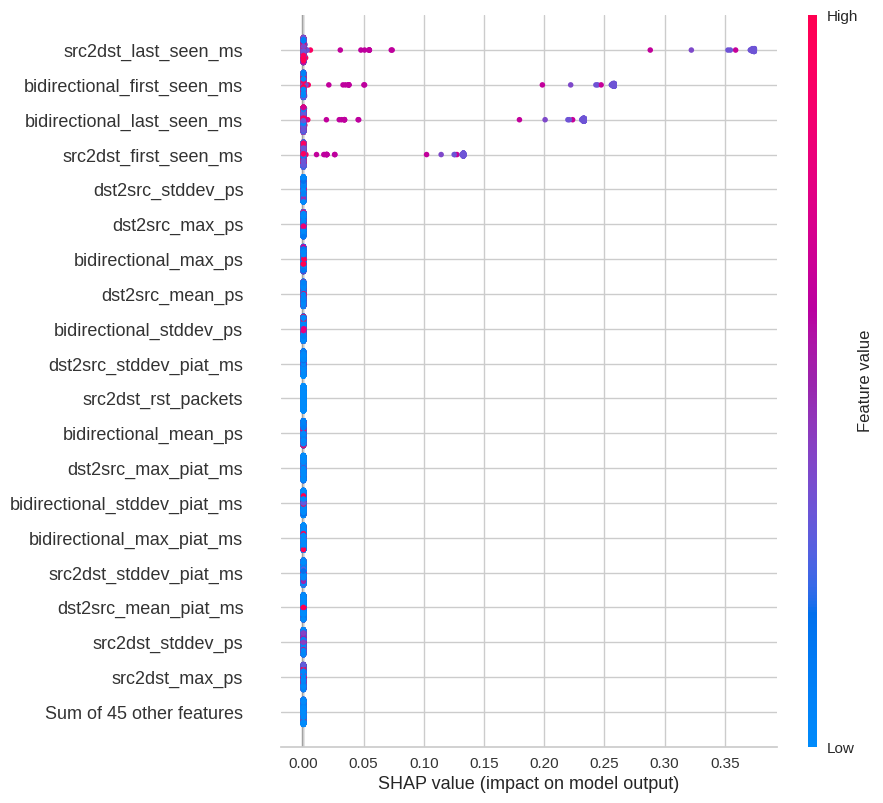

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

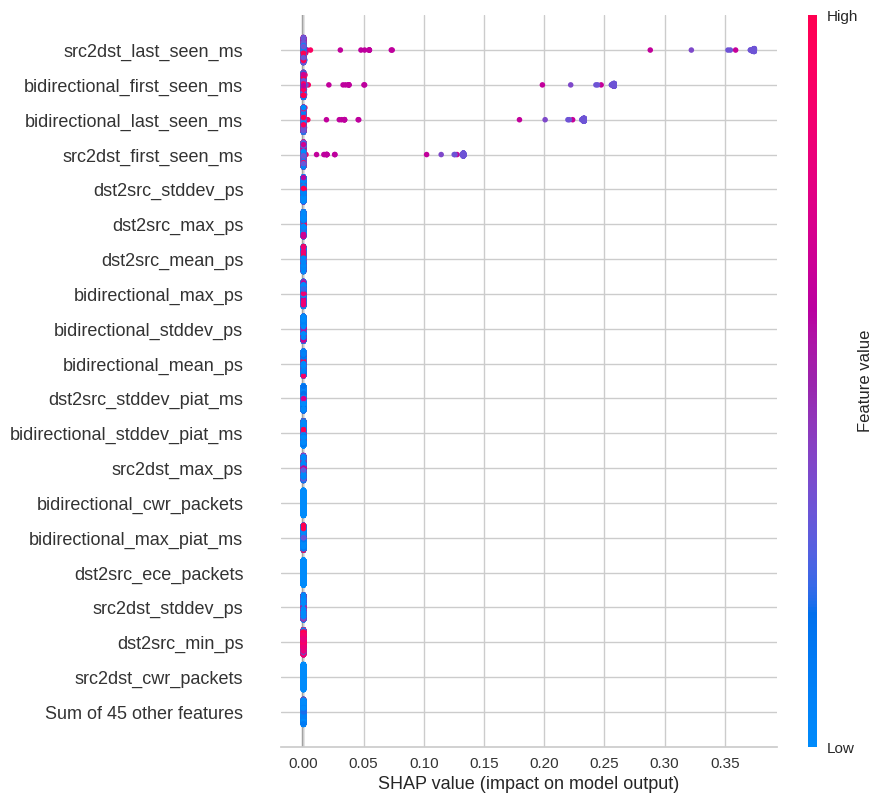

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## DoS Hulk shap

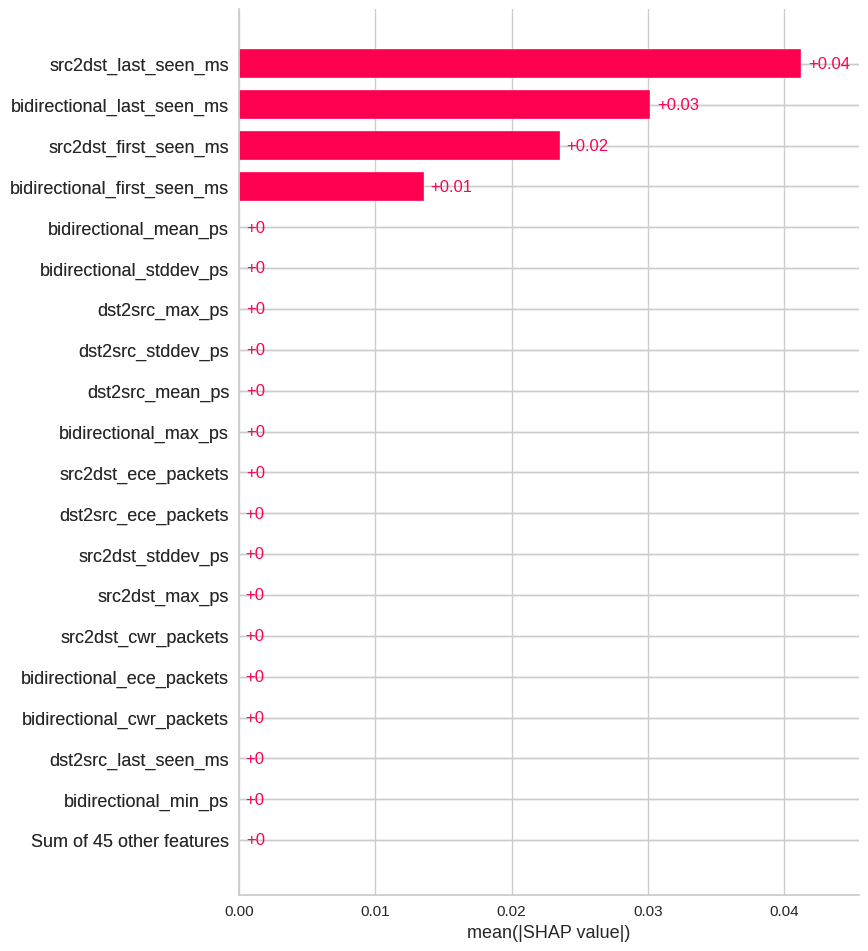

In [ ]:
exp = Explanation(sv[4],
              explainer.expected_value[4],
              data=foreground, 
              feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
plt.show()

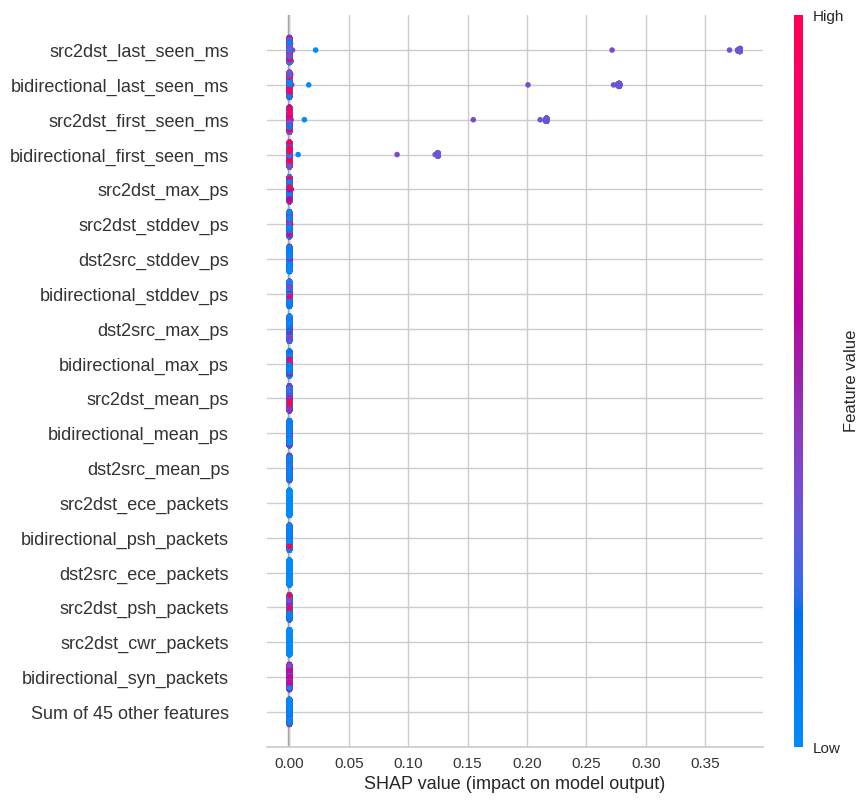

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

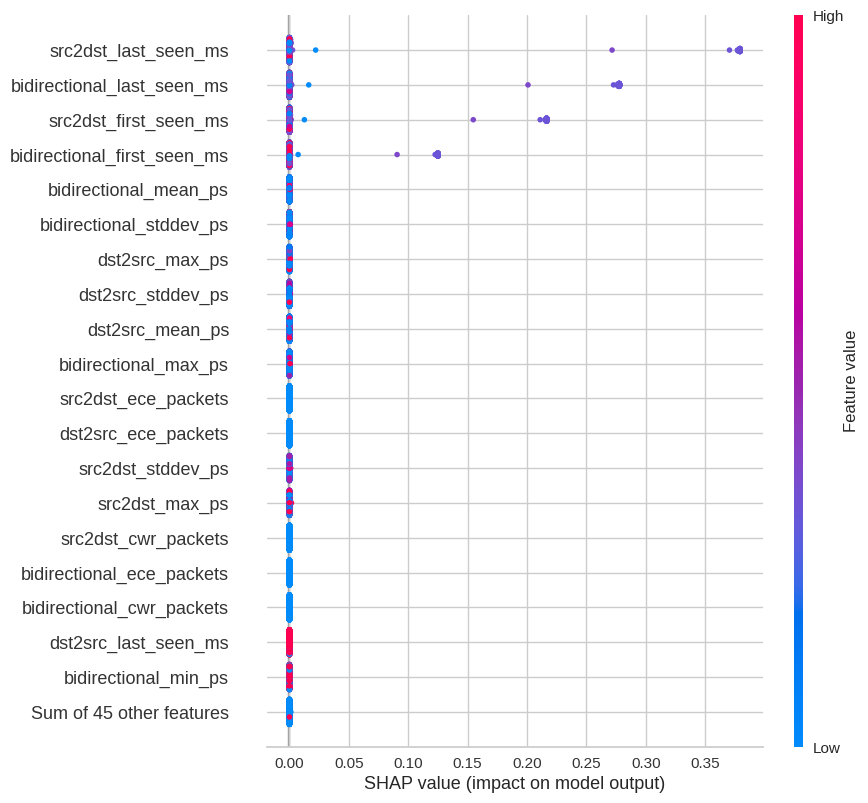

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## DoS Slowhttptest shap

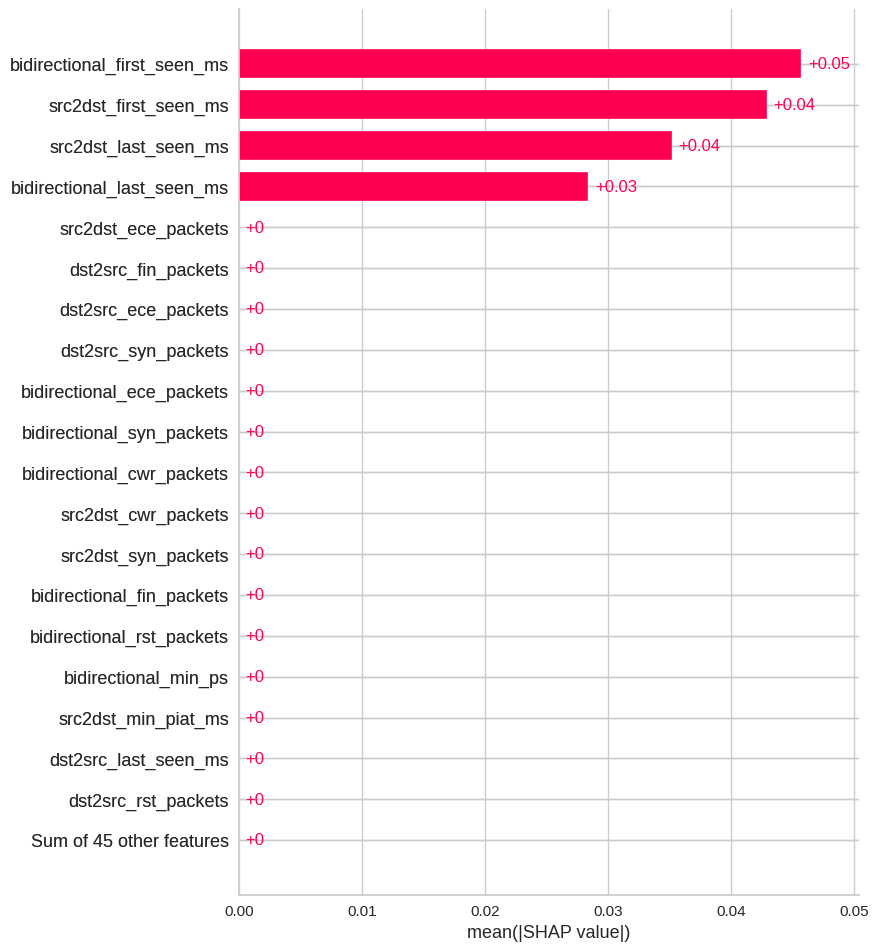

In [ ]:
exp = Explanation(sv[5],
              explainer.expected_value[5],
              data=foreground, 
              feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
plt.show()

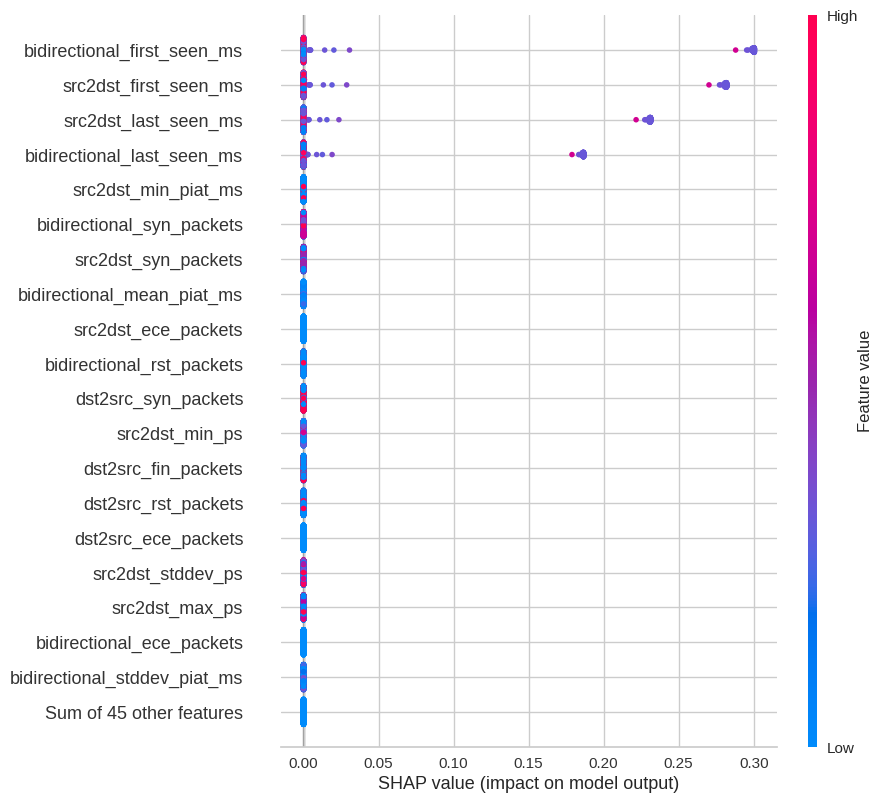

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

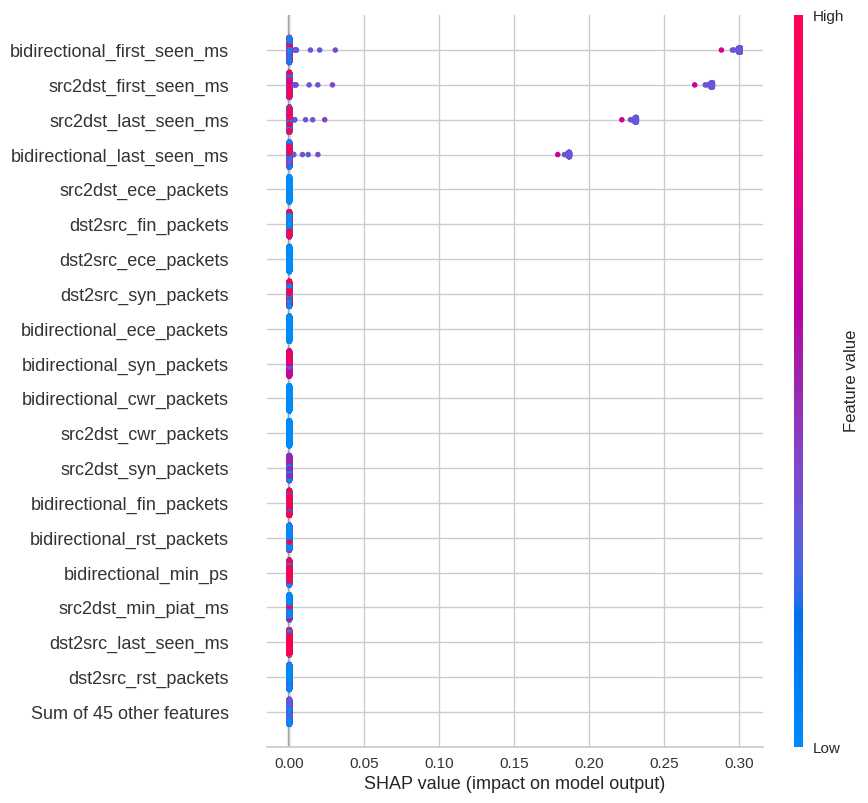

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## DoS slowloris shap

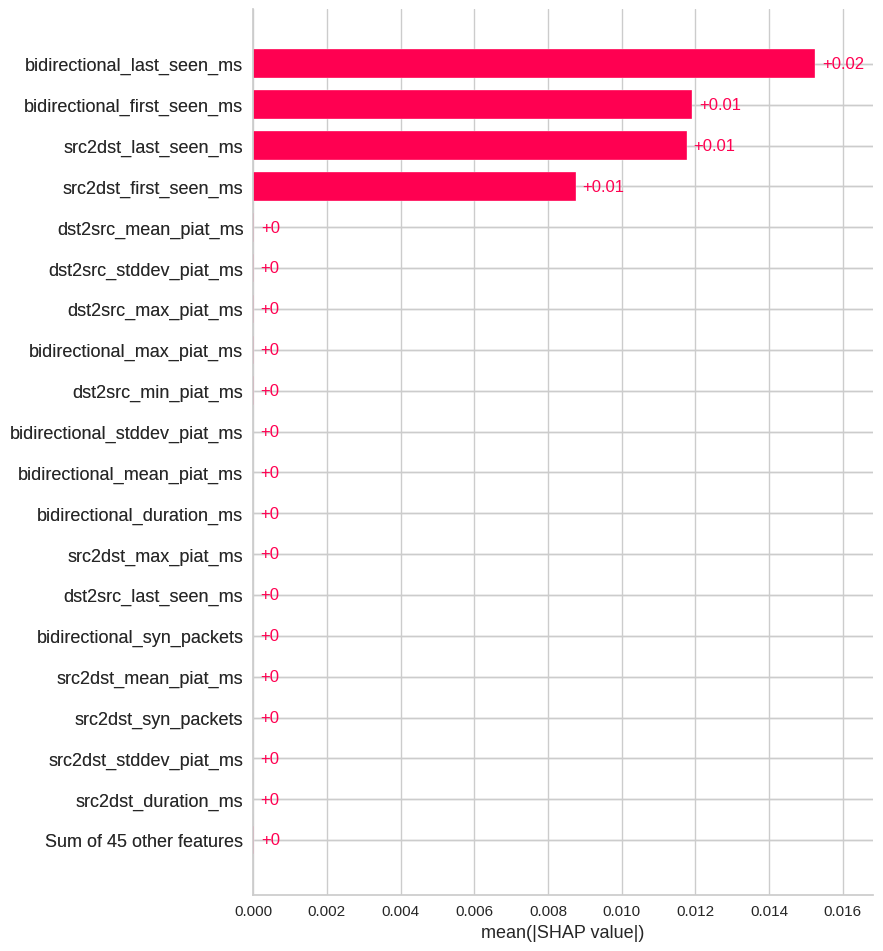

In [ ]:
exp = Explanation(sv[6],
              explainer.expected_value[6],
              data=foreground, 
              feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
plt.show()

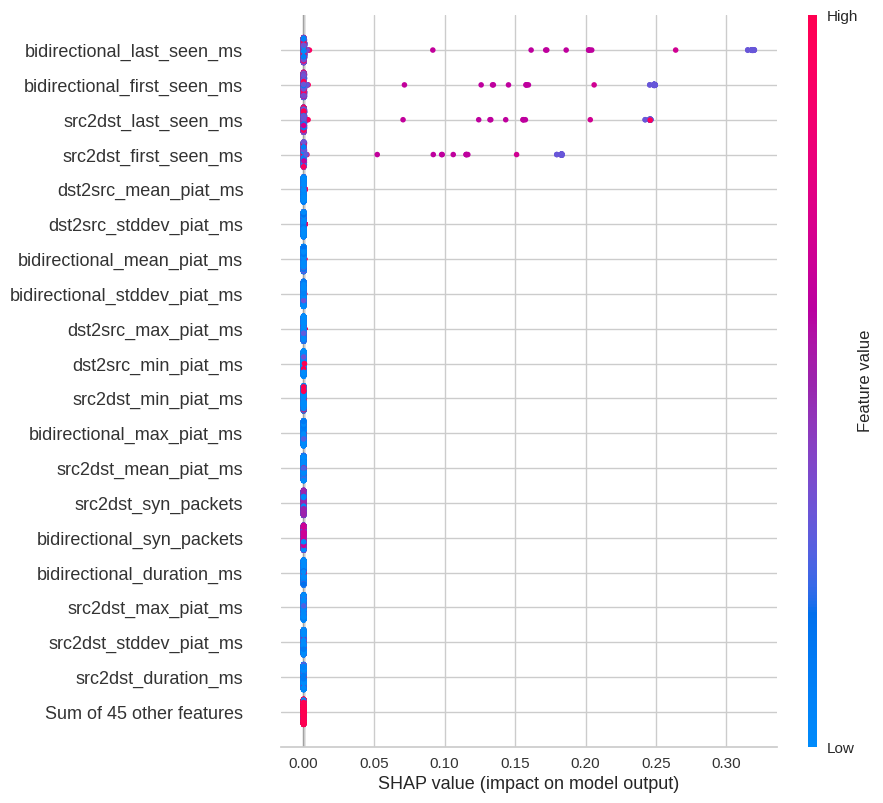

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

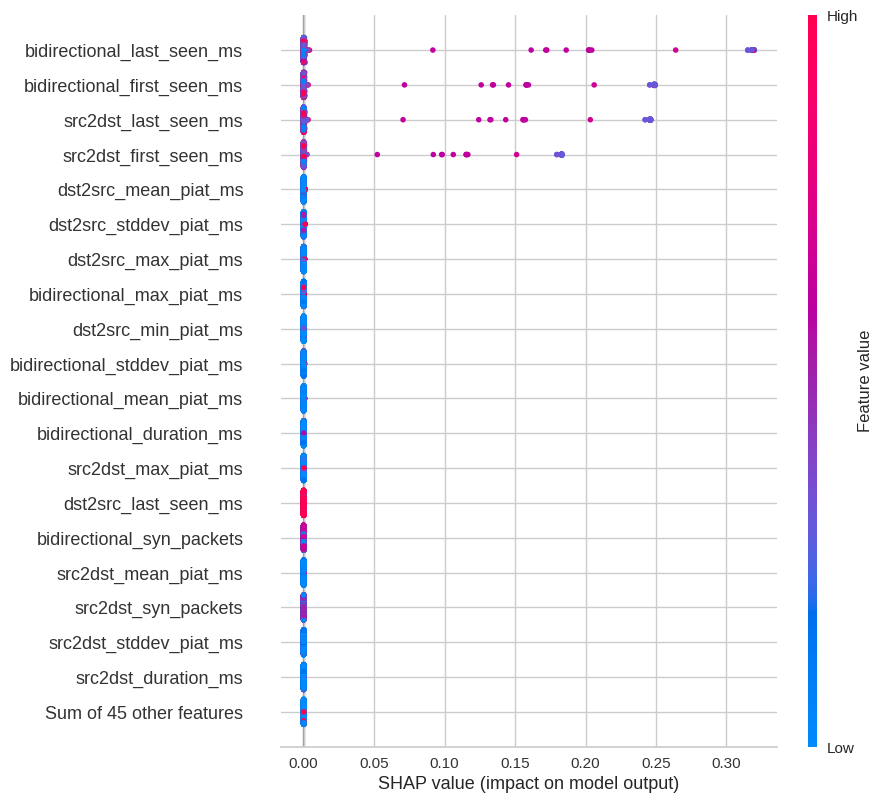

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## FTP-Patator shap

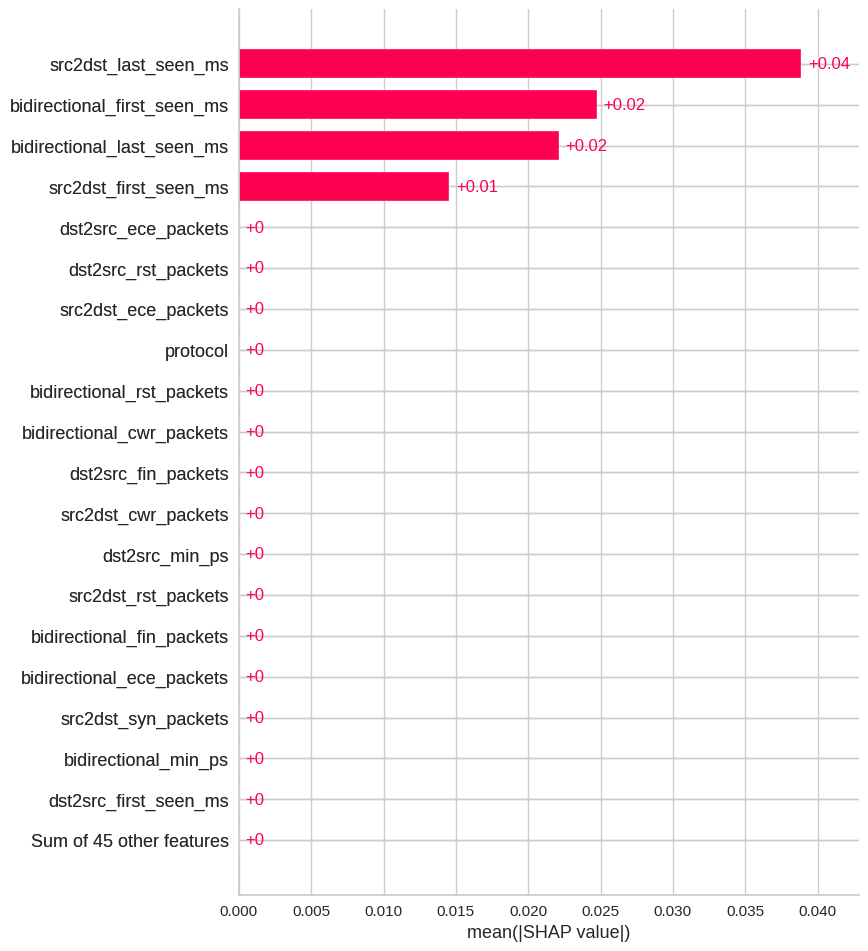

In [ ]:
exp = Explanation(sv[7],
              explainer.expected_value[7],
              data=foreground, 
              feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
plt.show()

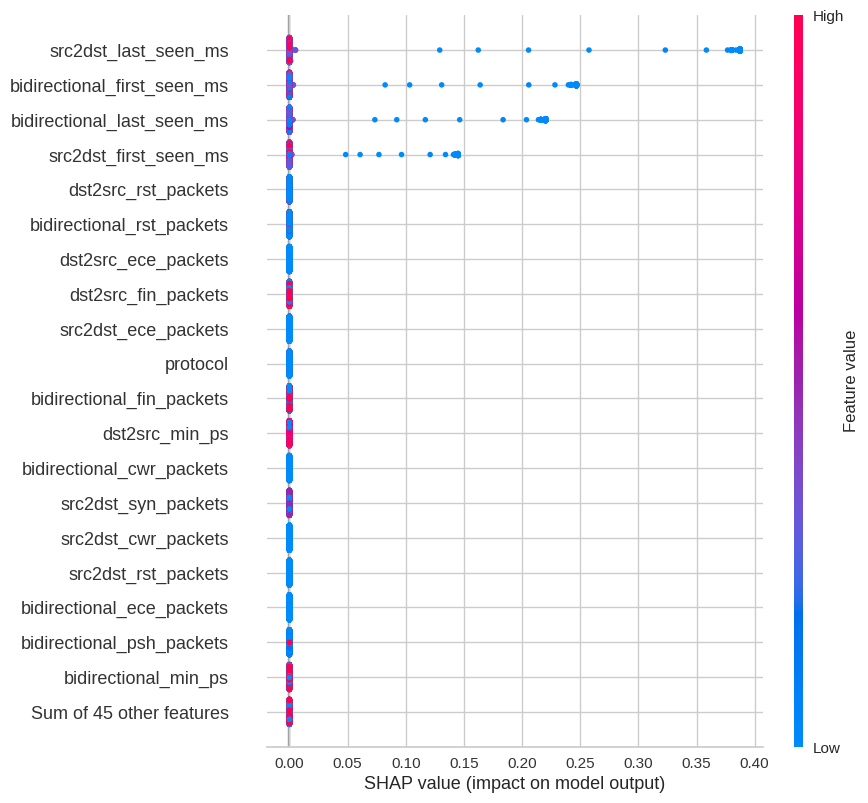

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

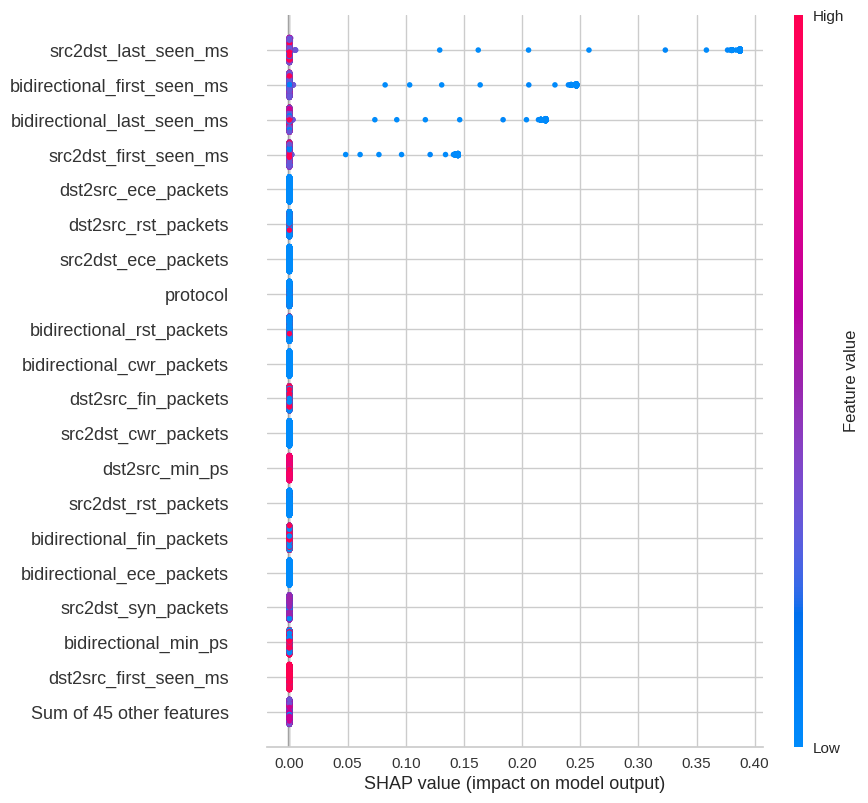

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Heartbleed shap

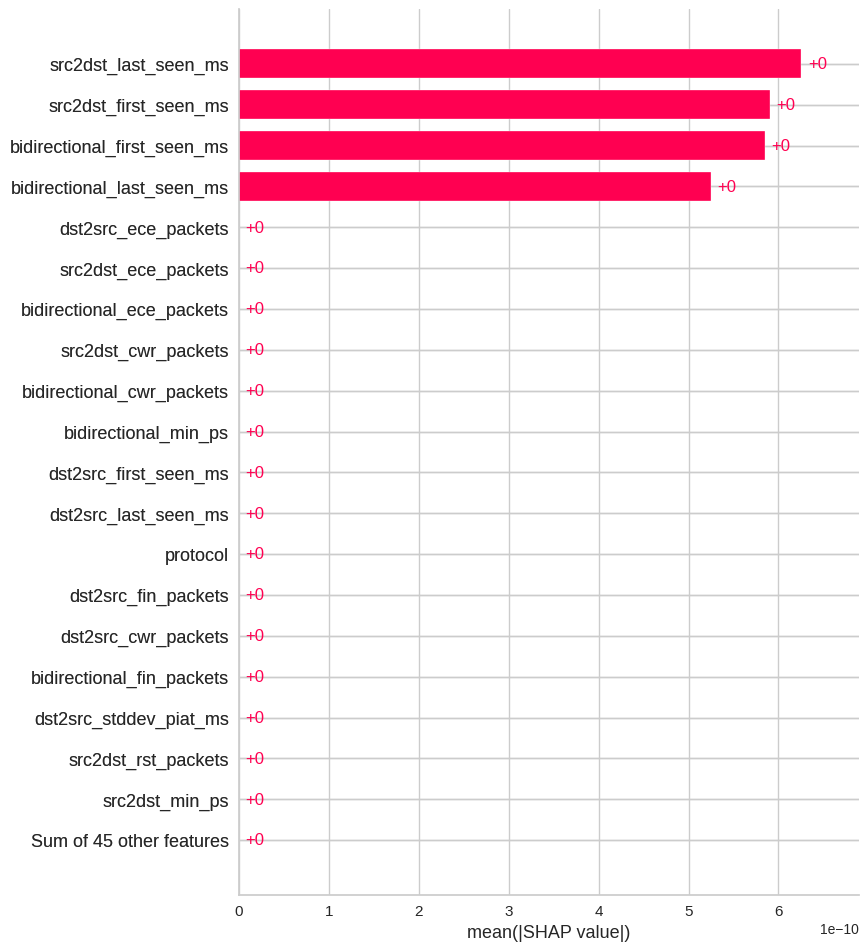

In [ ]:
exp = Explanation(sv[8],
              explainer.expected_value[8],
              data=foreground, 
              feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
plt.show()

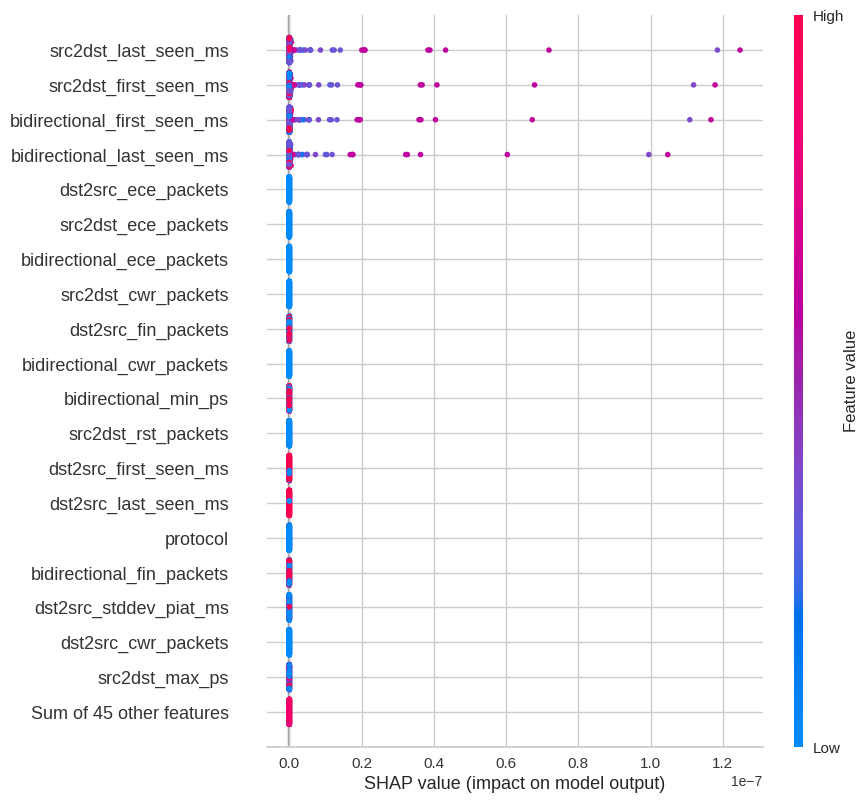

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

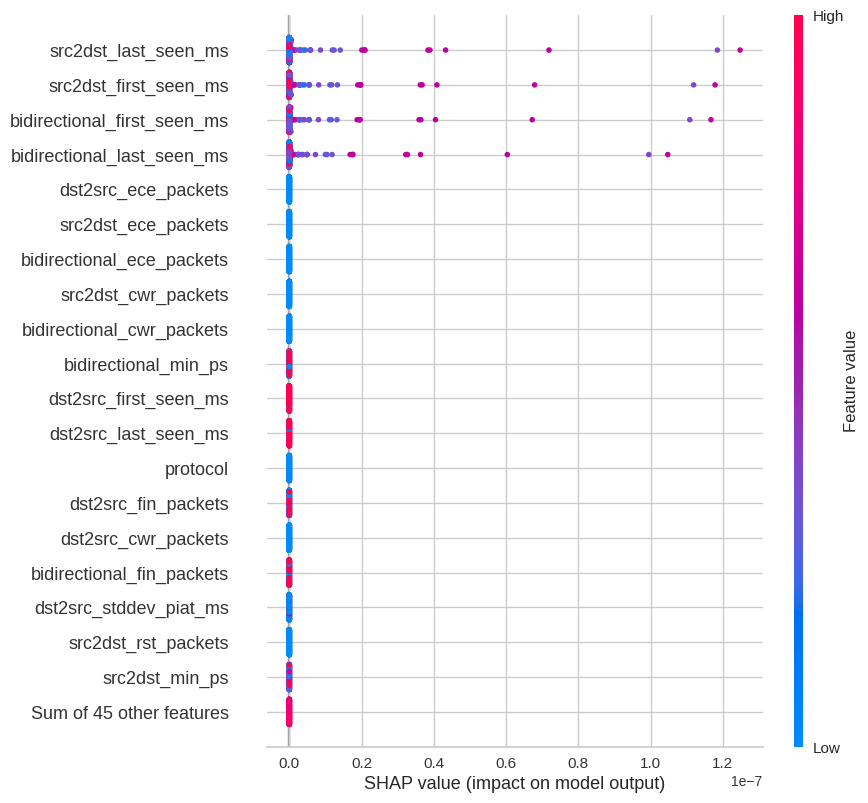

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Infiltration shap

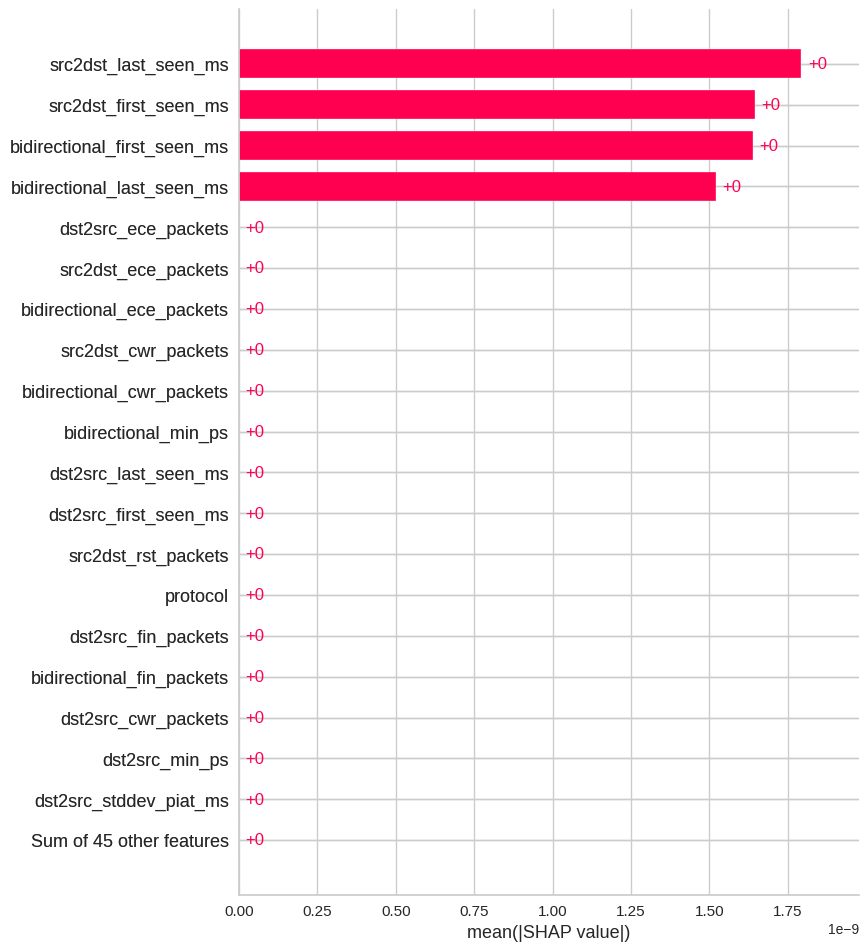

In [ ]:
exp = Explanation(sv[9],
              explainer.expected_value[9],
              data=foreground, 
              feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
plt.show()

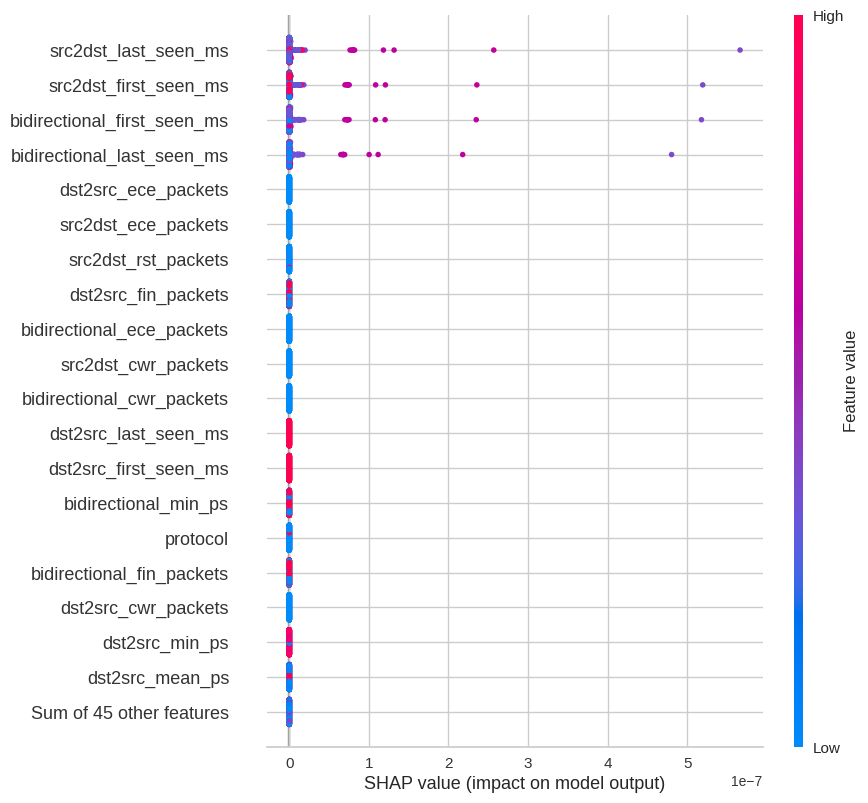

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

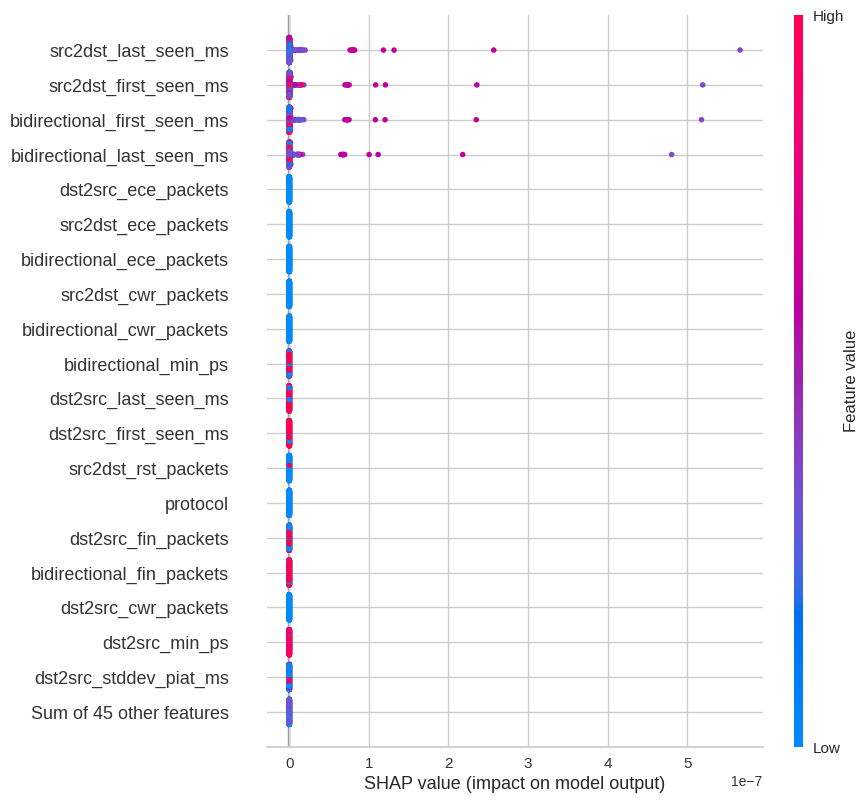

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## PortScan shap

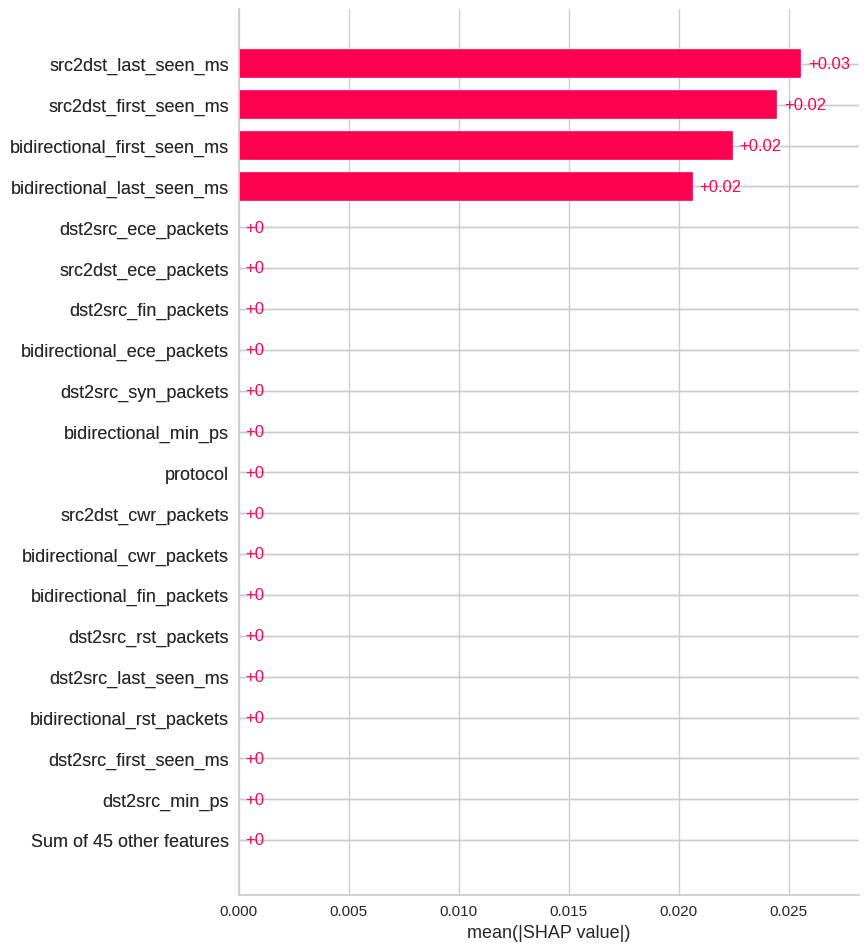

In [ ]:
exp = Explanation(sv[10],
              explainer.expected_value[10],
              data=foreground, 
              feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
plt.show()

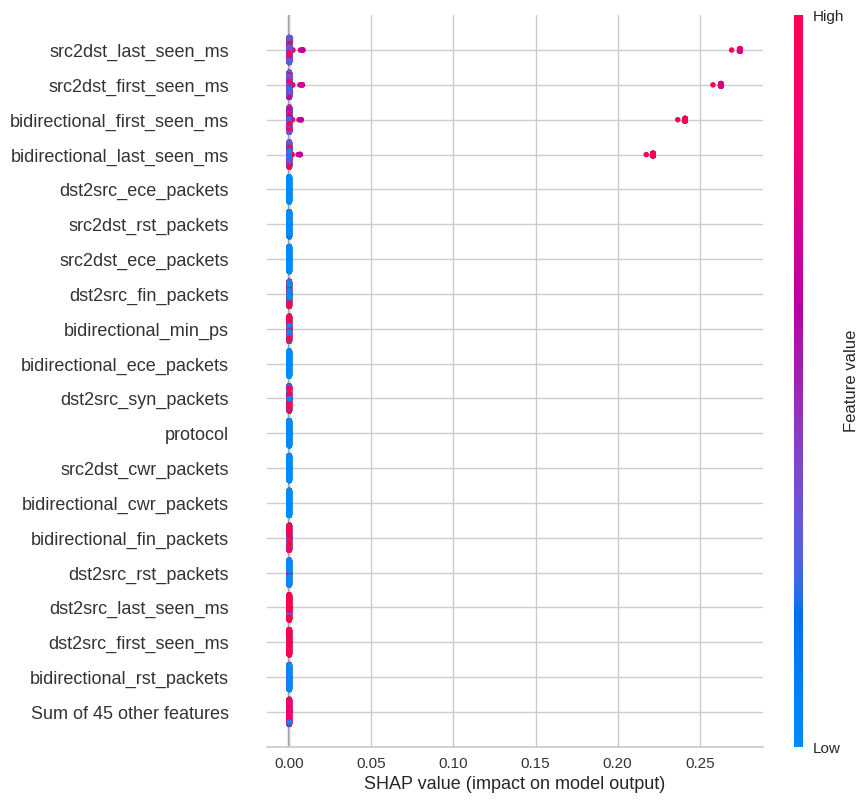

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

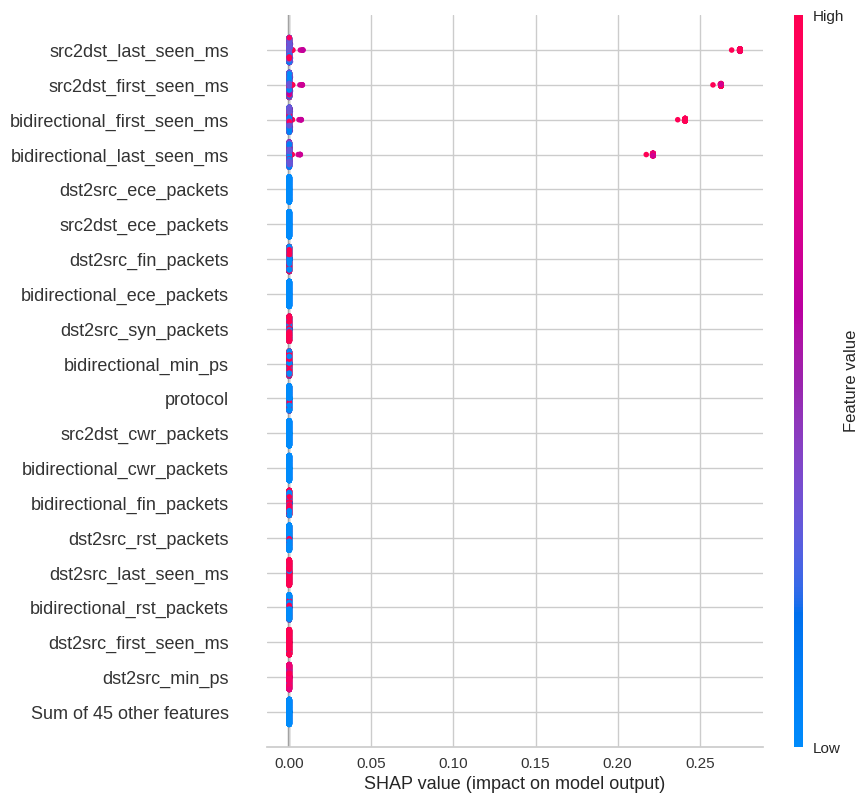

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## SSH-Patator shap

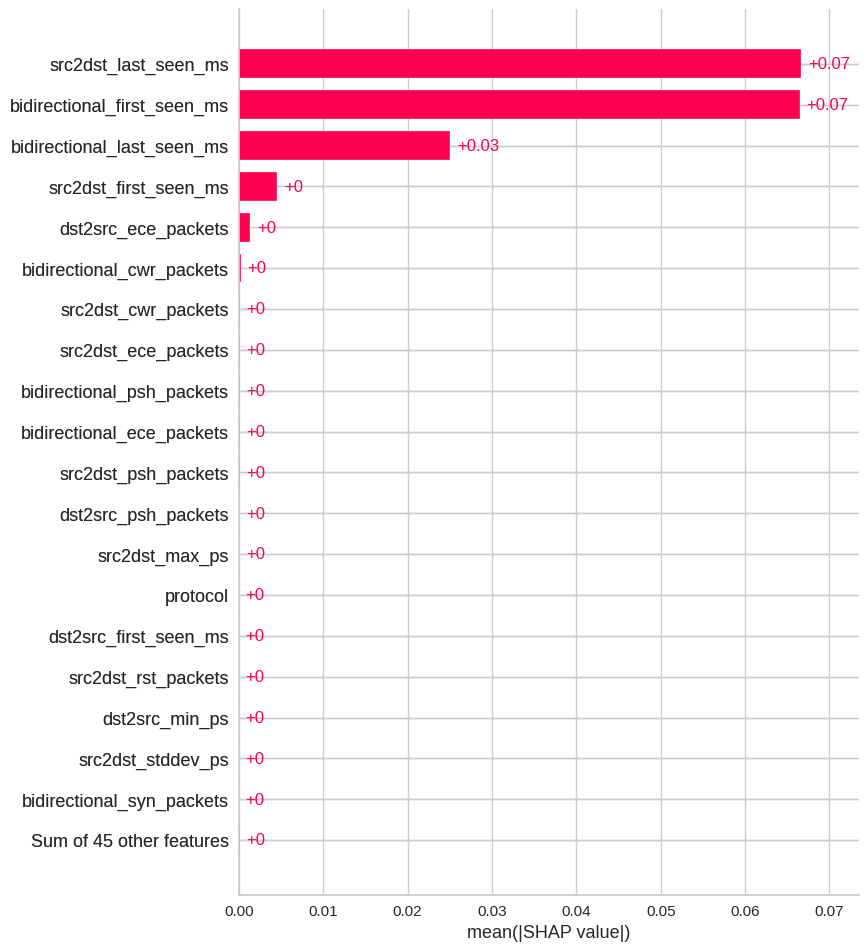

In [ ]:
exp = Explanation(sv[11],
              explainer.expected_value[11],
              data=foreground, 
              feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
plt.show()

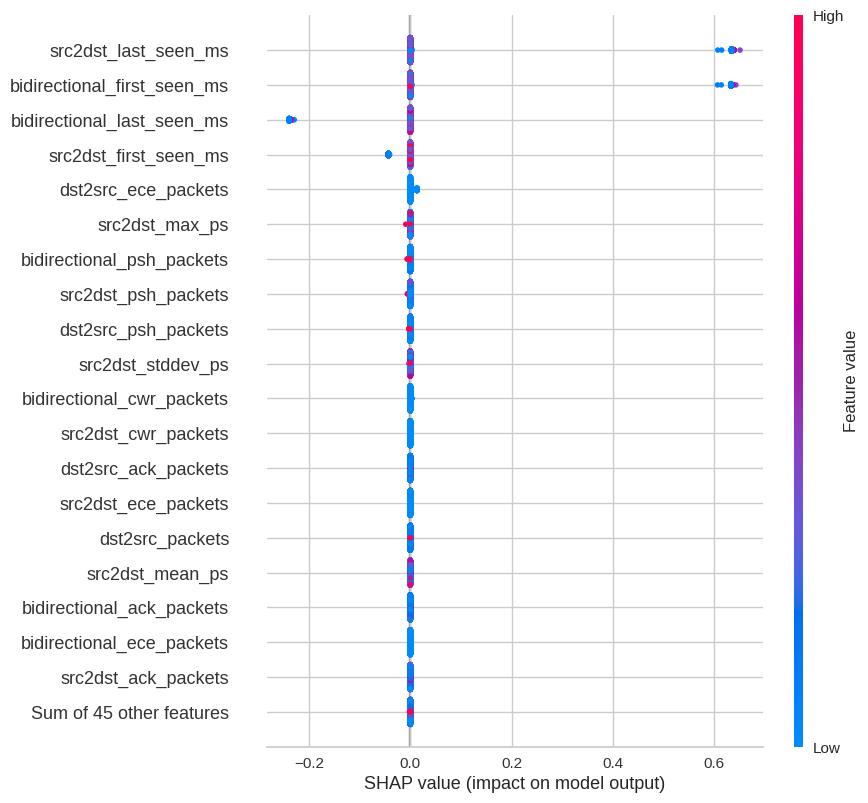

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

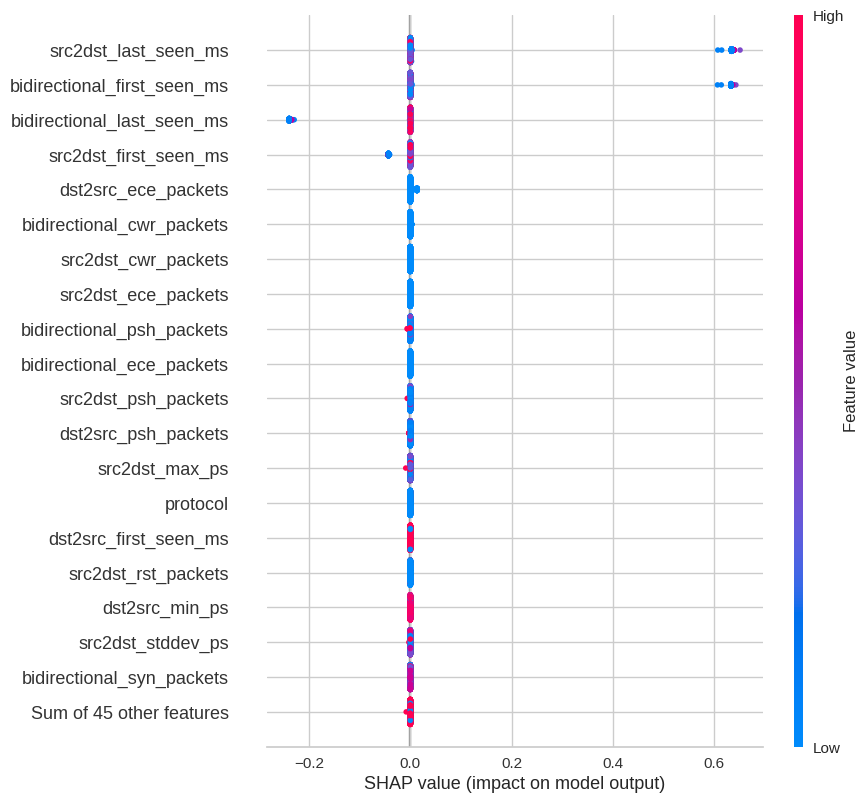

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Web Attack - Brute Force shap

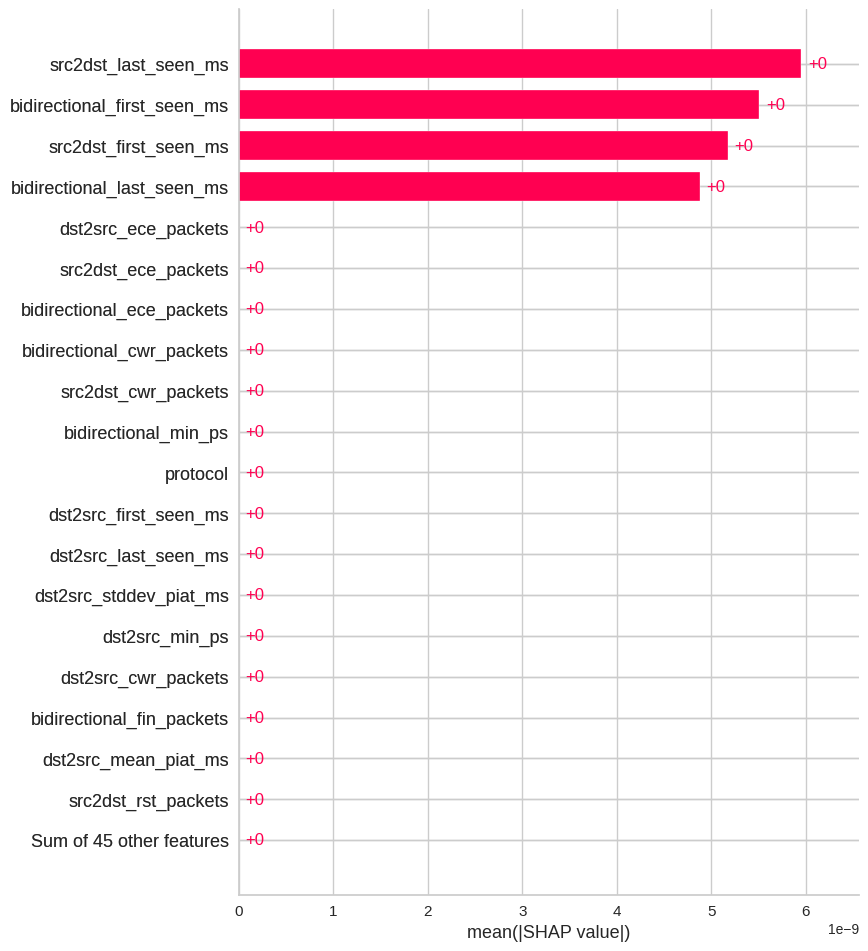

In [ ]:
exp = Explanation(sv[12],
              explainer.expected_value[12],
              data=foreground, 
              feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
plt.show()

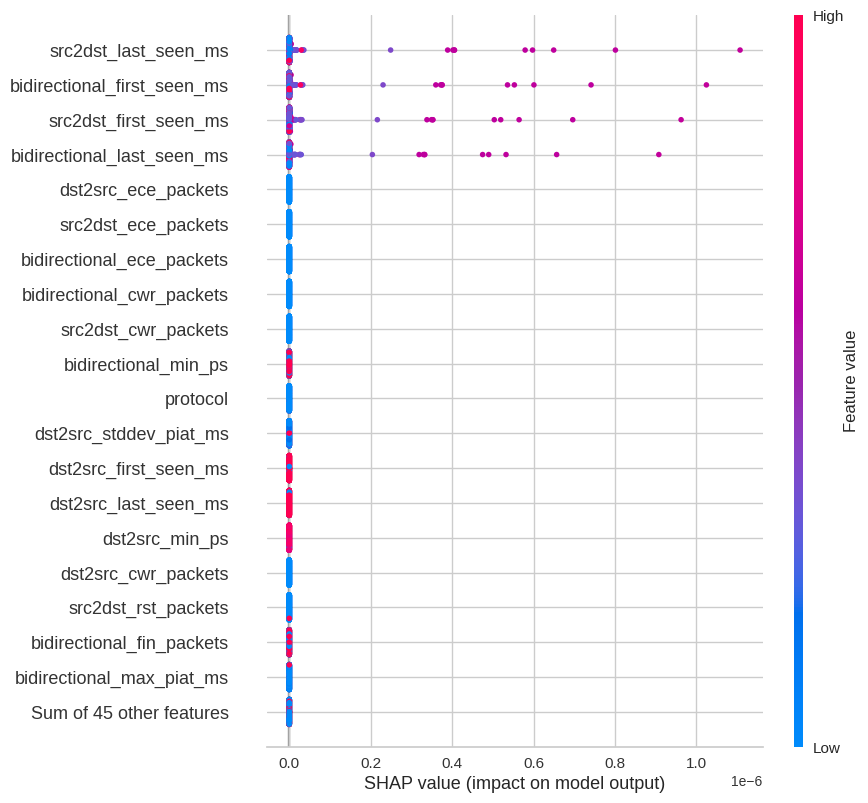

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

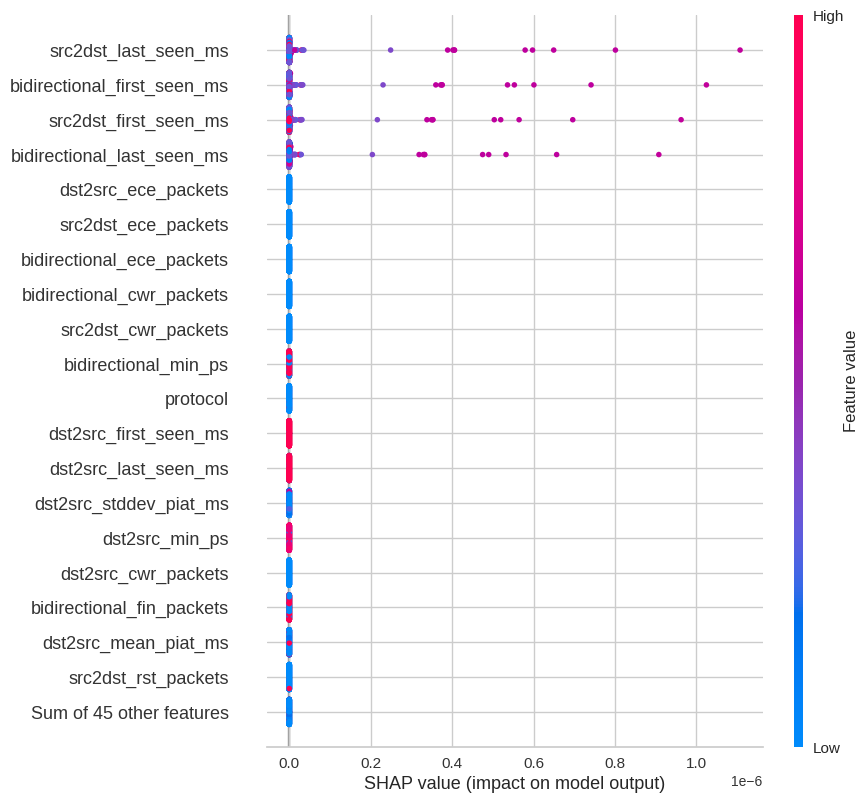

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Web Attack - Sql Injection shap

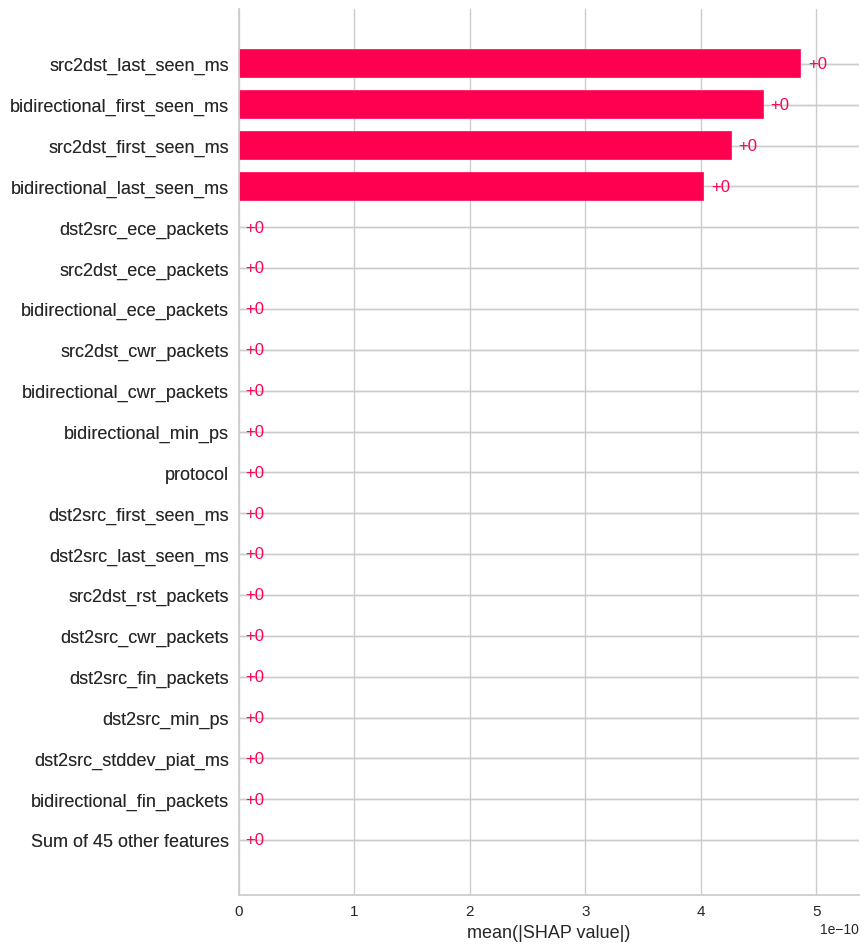

In [ ]:
exp = Explanation(sv[13],
              explainer.expected_value[13],
              data=foreground, 
              feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
plt.show()

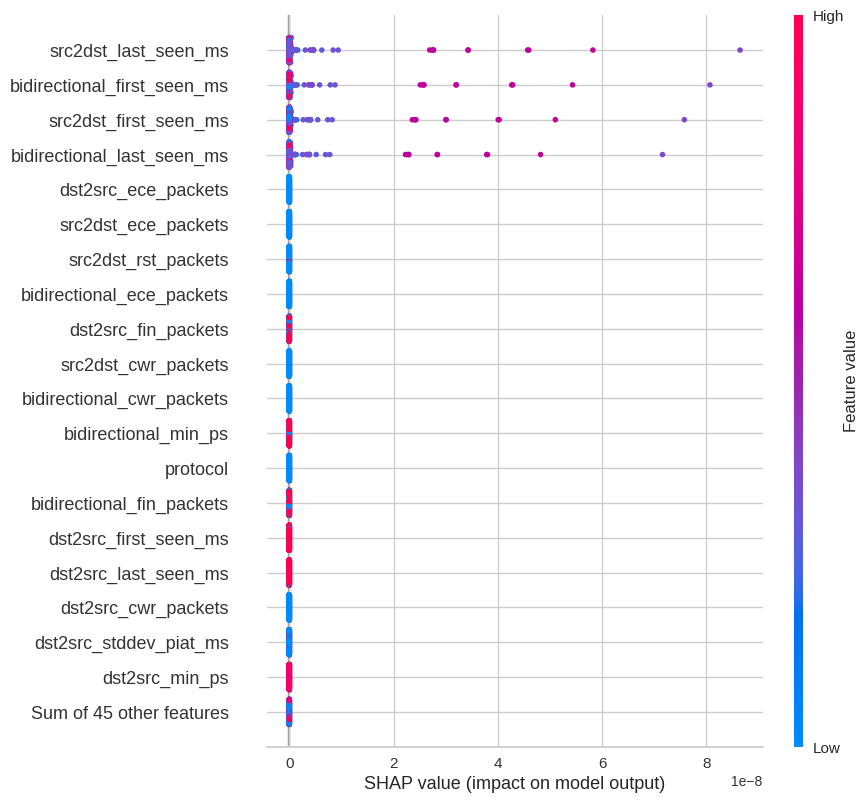

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

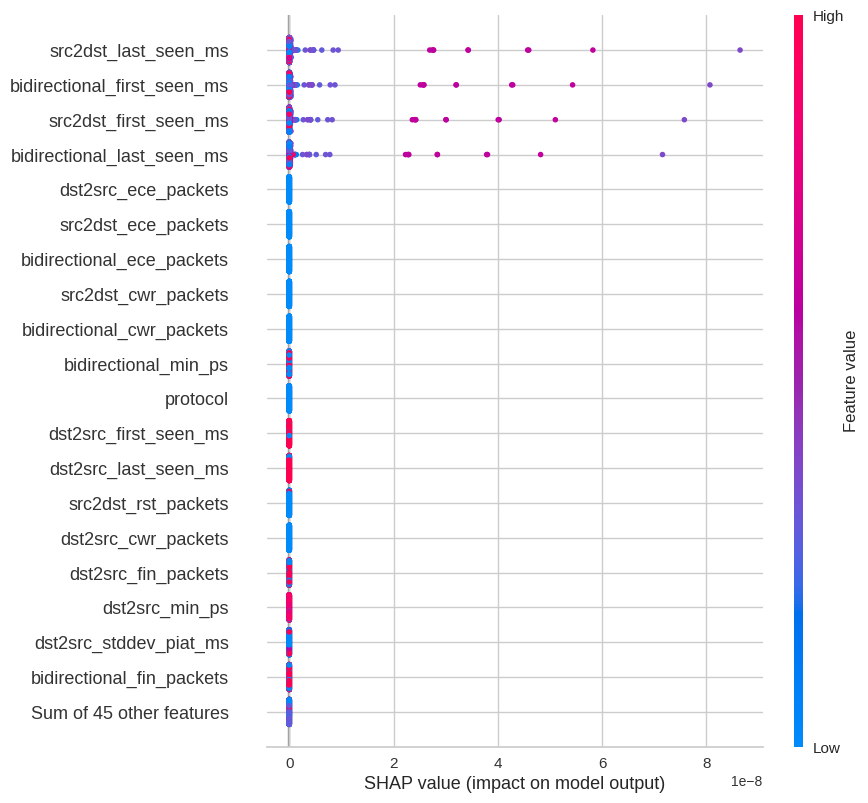

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Web Attack - XSS shap

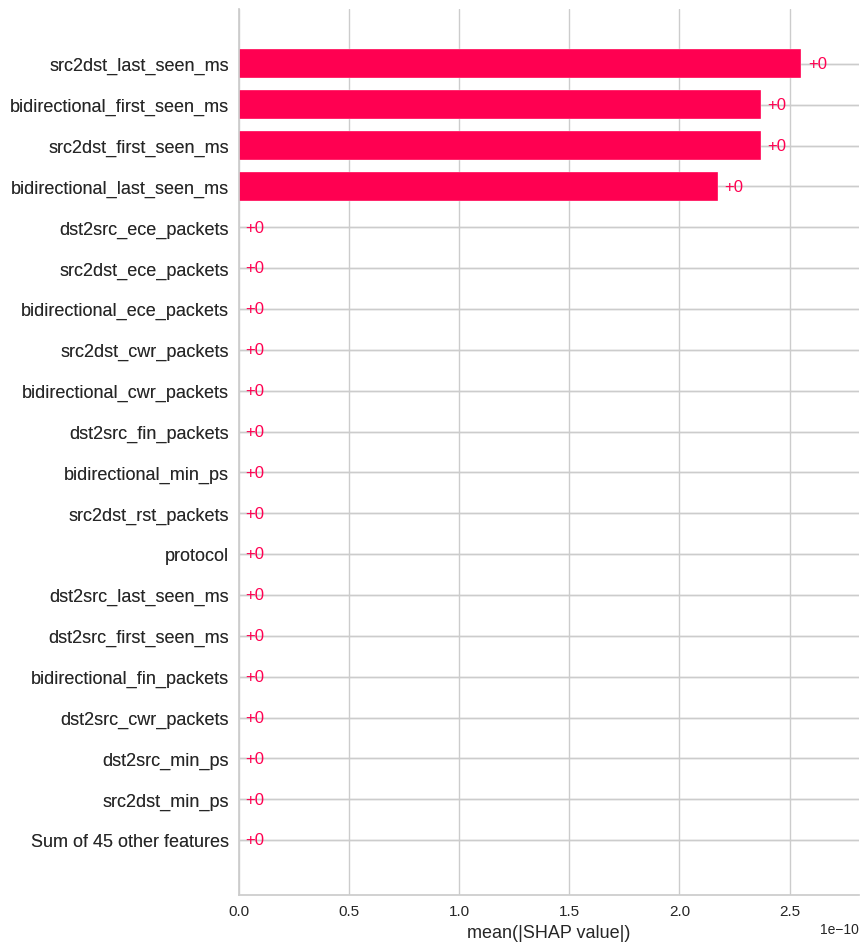

In [ ]:
exp = Explanation(sv[14],
              explainer.expected_value[14],
              data=foreground, 
              feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
plt.show()

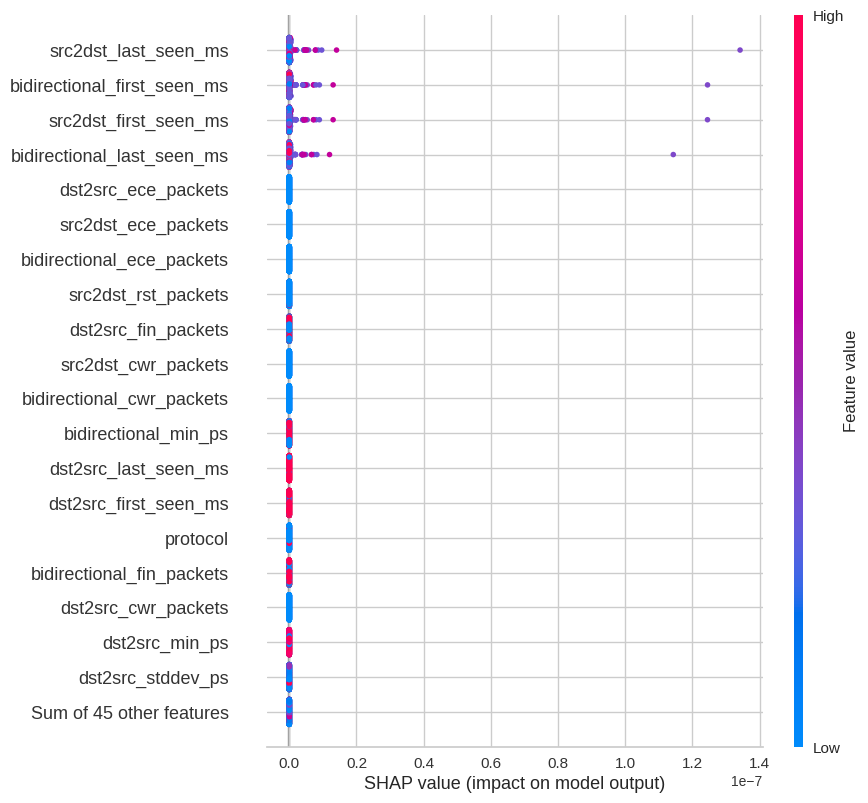

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

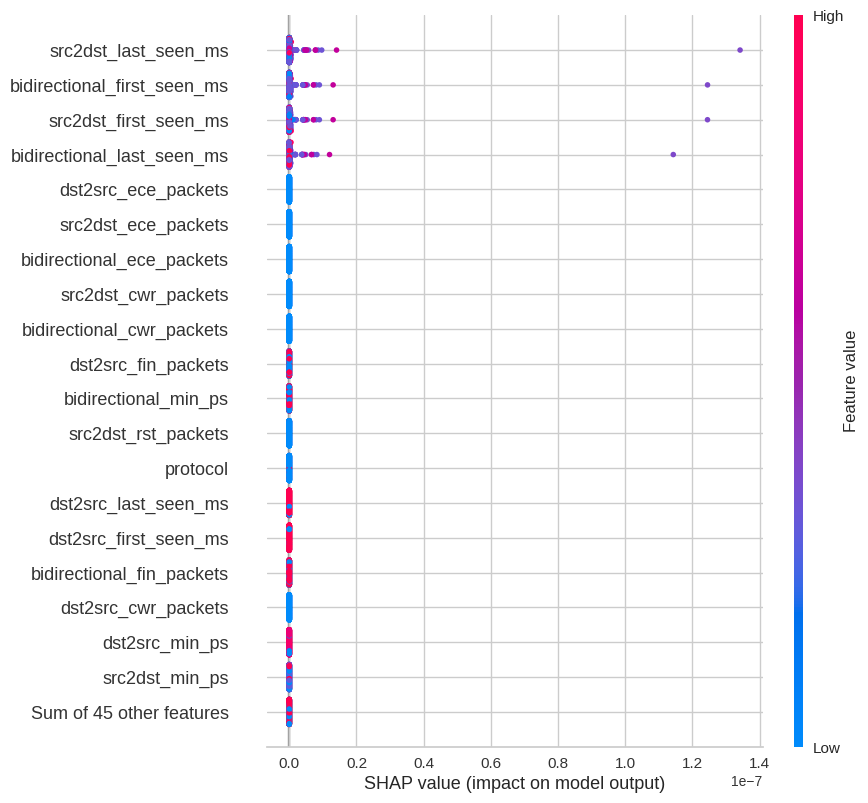

In [ ]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Overall importance

In [ ]:
overall_sv = np.zeros(64)

count = 0

for i in sv:
    for j in i:
        overall_sv = overall_sv + j
        count += 1

overall_sv = overall_sv / count

In [ ]:
plots.bar(overall_sv, max_display=20, show=False)

TypeError: The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!

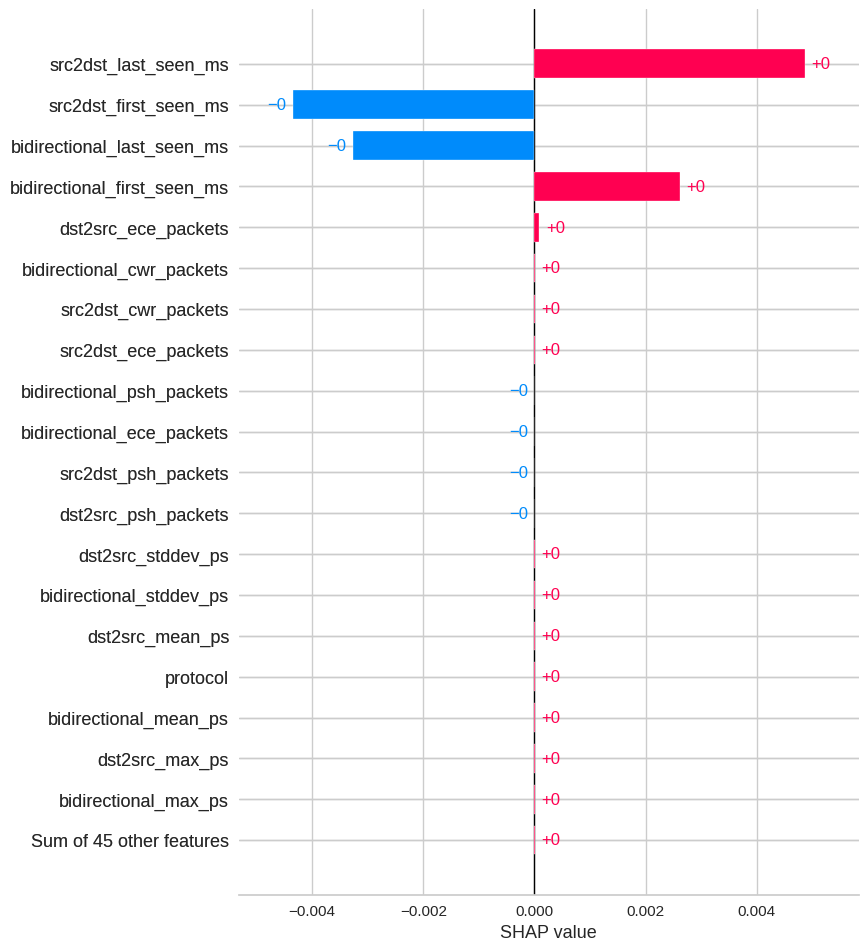

In [ ]:
exp = Explanation(overall_sv,
              feature_names=X_res.columns)

plots.bar(exp, max_display=20, show=False)
plt.show()

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

ValueError: The beeswarm plot does not support plotting a single instance, please pass an explanation matrix with many instances!

# Zero day test

In [94]:
classes = sorted(pd.unique(ds['traffic_category']).tolist())

In [95]:
y_train_attack = y_train[y_train != 2]
X_train_attack = X_train[y_train != 2]
model.fit(X_train_attack, y_train_attack)
y_predicted_train = model.predict(X_train_attack)
y_predicted_test = model.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

No improvement for 10 epochs, stopping.
Execution time:  1.3615093231201172


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Measure     Train      Test
0   ACCURACY  0.814002  0.685375
1  PRECISION  0.832160  0.792255
2     RECALL  0.814002  0.685375
3   F1 SCORE  0.789869  0.628470

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


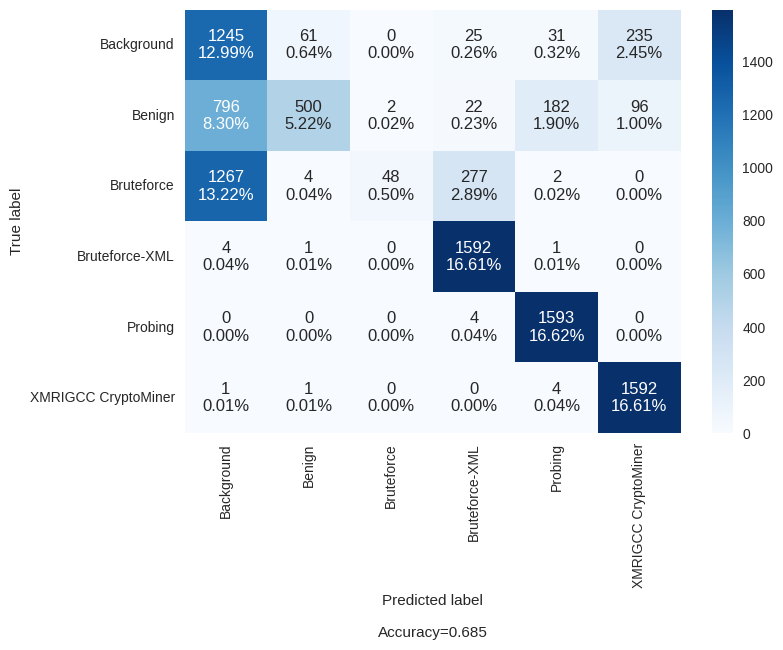

In [96]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [97]:
y_train_attack = y_train[y_train != 3]
X_train_attack = X_train[y_train != 3]
model.fit(X_train_attack, y_train_attack)
y_predicted_train = model.predict(X_train_attack)
y_predicted_test = model.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

No improvement for 10 epochs, stopping.
Execution time:  2.0857760906219482


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Measure     Train      Test
0   ACCURACY  0.813314  0.680054
1  PRECISION  0.832411  0.646765
2     RECALL  0.813314  0.680054
3   F1 SCORE  0.789476  0.624629

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


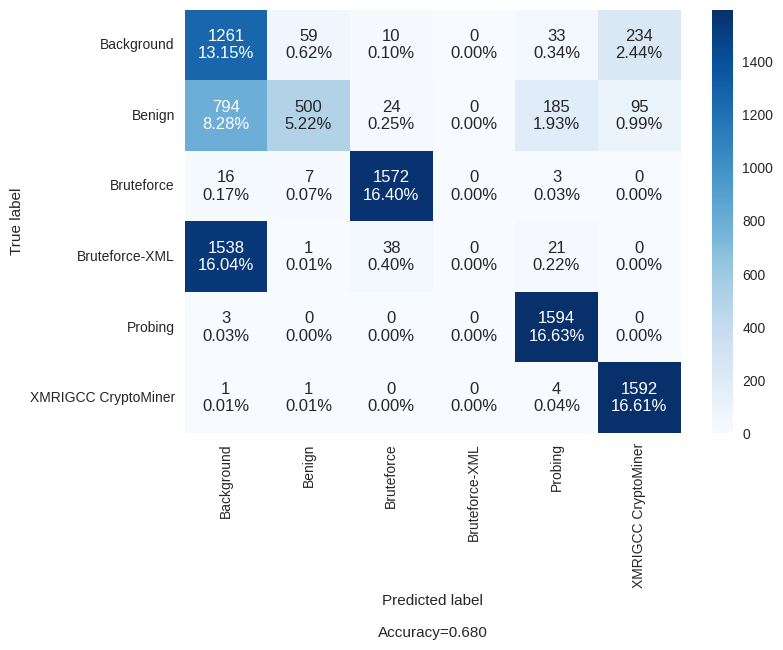

In [98]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [99]:
y_train_attack = y_train[y_train != 4]
X_train_attack = X_train[y_train != 4]
model.fit(X_train_attack, y_train_attack)
y_predicted_train = model.predict(X_train_attack)
y_predicted_test = model.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

No improvement for 10 epochs, stopping.
Execution time:  1.9145007133483887


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Measure     Train      Test
0   ACCURACY  0.831367  0.707907
1  PRECISION  0.854676  0.742962
2     RECALL  0.831367  0.707907
3   F1 SCORE  0.819752  0.672374

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


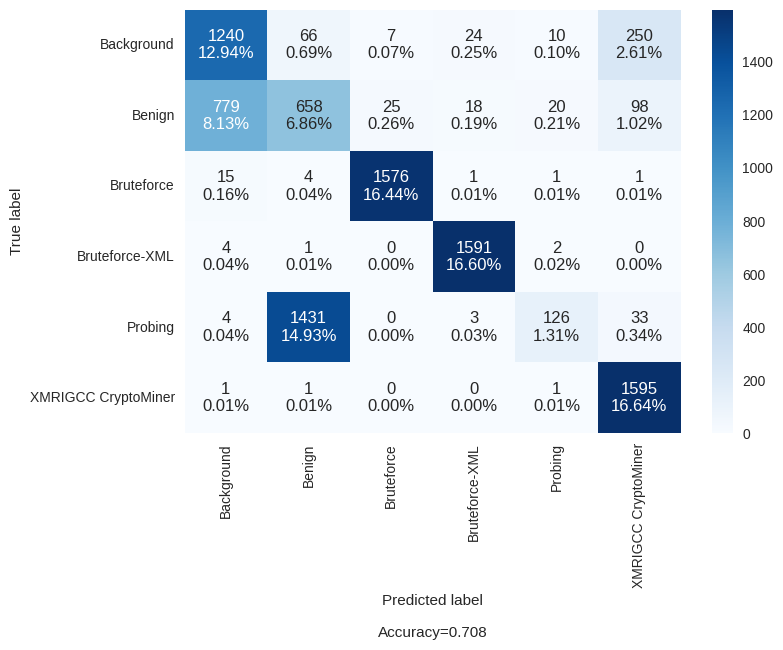

In [100]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [101]:
y_train_attack = y_train[y_train != 5]
X_train_attack = X_train[y_train != 5]
model.fit(X_train_attack, y_train_attack)
y_predicted_train = model.predict(X_train_attack)
y_predicted_test = model.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

No improvement for 10 epochs, stopping.
Execution time:  3.192613124847412


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Measure     Train      Test
0   ACCURACY  0.820825  0.699562
1  PRECISION  0.831274  0.710467
2     RECALL  0.820825  0.699562
3   F1 SCORE  0.810544  0.671566

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


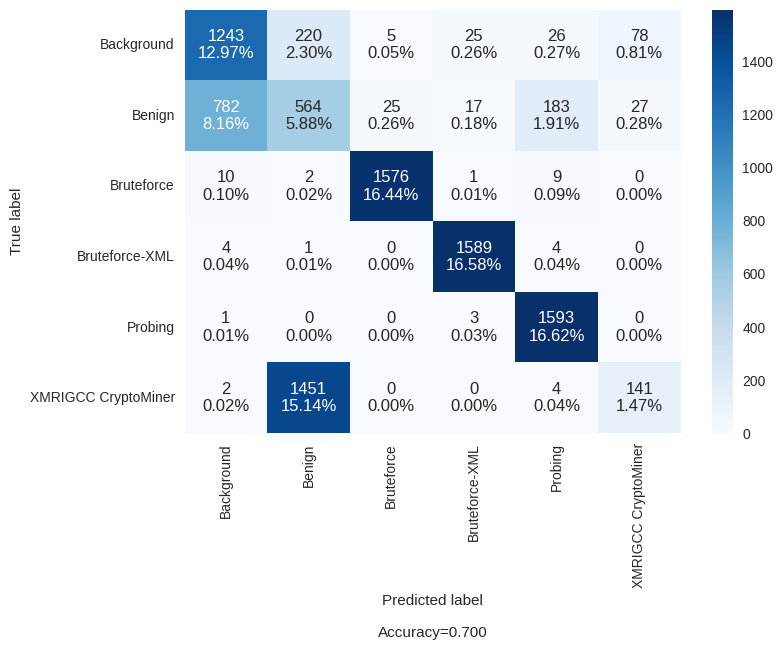

In [102]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')